Mediana ruido (dB): -66.302
Sigma robusta (dB): 0.156
Umbral alto thr_hi (dB): -65.834
Umbral bajo thr_lo (dB): -66.146

✅ Emisiones detectadas: 30

[1] f_start=89.662547 MHz, f_end=89.758369 MHz, fc=89.729073 MHz, peak=-65.35 dB, BW~96.43 kHz
[2] f_start=89.810247 MHz, f_end=89.813299 MHz, fc=89.811468 MHz, peak=-65.75 dB, BW~3.66 kHz
[3] f_start=89.998230 MHz, f_end=90.001282 MHz, fc=90.000061 MHz, peak=-65.74 dB, BW~3.66 kHz
[4] f_start=90.263114 MHz, f_end=90.313772 MHz, fc=90.302176 MHz, peak=-65.06 dB, BW~51.27 kHz
[5] f_start=91.631481 MHz, f_end=91.762702 MHz, fc=91.705941 MHz, peak=-63.07 dB, BW~131.83 kHz
[6] f_start=92.296133 MHz, f_end=92.305288 MHz, fc=92.300406 MHz, peak=-62.98 dB, BW~9.77 kHz
[7] f_start=92.665385 MHz, f_end=92.667826 MHz, fc=92.666605 MHz, peak=-63.78 dB, BW~3.05 kHz
[8] f_start=92.998627 MHz, f_end=93.001068 MHz, fc=92.999847 MHz, peak=-62.83 dB, BW~3.05 kHz
[9] f_start=95.662119 MHz, f_end=95.771369 MHz, fc=95.699350 MHz, peak=-63.32 dB, BW~109.86 kHz

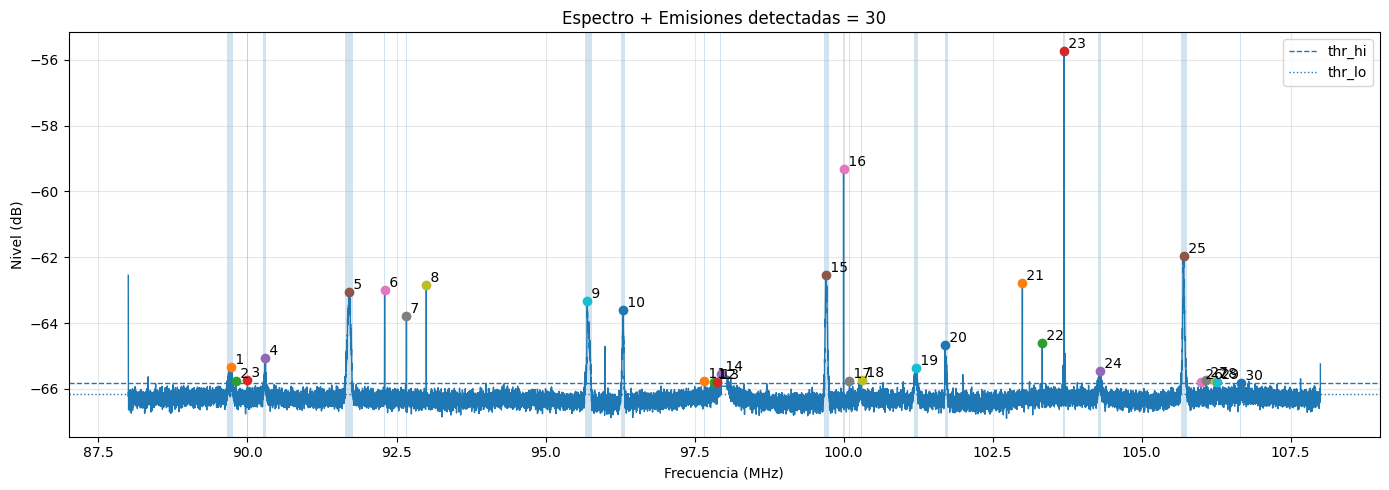

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences

# =========================
# 1) Cargar JSON
# =========================
# En Colab, sube tu archivo y pon aquí el nombre:
JSON_PATH = "D:\kl_psd\spectrum_camp-ane2-test3_medicion20_2025-12-16T16-11-57 (1).json"

with open(JSON_PATH, "r") as f:
    d = json.load(f)

pxx_db = np.asarray(d["Pxx"], dtype=float)
f_start = float(d["start_freq_hz"])
f_end   = float(d["end_freq_hz"])

N = len(pxx_db)
# Usamos endpoint=False para que el último bin no caiga exactamente en f_end
freq_hz = np.linspace(f_start, f_end, N, endpoint=False)

# =========================
# 2) Umbral robusto (MAD)
# =========================
def robust_noise_stats(x_db):
    med = np.median(x_db)
    mad = np.median(np.abs(x_db - med)) + 1e-12
    sigma = 1.4826 * mad  # aprox sigma si el ruido es gaussiano
    return med, sigma

# =========================
# 3) Detectar emisiones (regiones)
# =========================
def detect_emissions_regions(
    x_db, f_hz,
    n_sigma=20.0,            # sube/baja para ser más estricto
    hysteresis_sigma=2.0,    # para expandir regiones con umbral más bajo
    min_prom_db=4.0,         # prominencia mínima del pico (dB)
    min_width_bins=5,        # ancho mínimo en bins
    merge_gap_bins=40        # fusionar regiones separadas por <= gap
):
    med, sigma = robust_noise_stats(x_db)
    thr_hi = med + n_sigma * sigma
    thr_lo = thr_hi - hysteresis_sigma * sigma

    # picos candidatos
    peaks, props = find_peaks(x_db, height=thr_hi, prominence=min_prom_db)

    # construir regiones alrededor de cada pico (con histéresis)
    used = np.zeros(len(x_db), dtype=bool)
    regions = []

    # ordena por pico más alto primero (para evitar solapes raros)
    if len(peaks) > 0:
        order = np.argsort(x_db[peaks])[::-1]
        peaks = peaks[order]

    for p in peaks:
        if used[p]:
            continue

        l = p
        while l > 0 and x_db[l] > thr_lo:
            l -= 1
        r = p
        while r < len(x_db) - 1 and x_db[r] > thr_lo:
            r += 1

        if (r - l + 1) < min_width_bins:
            continue

        regions.append((l, r, p))
        used[l:r+1] = True

    if not regions:
        return {
            "med": med, "sigma": sigma, "thr_hi": thr_hi, "thr_lo": thr_lo,
            "emissions": []
        }

    # fusionar regiones cercanas
    regions.sort(key=lambda t: t[0])
    merged = [regions[0]]
    for l, r, p in regions[1:]:
        l0, r0, p0 = merged[-1]
        if l - r0 <= merge_gap_bins:
            # fusiona
            new_l = l0
            new_r = max(r0, r)
            new_p = p0 if x_db[p0] >= x_db[p] else p
            merged[-1] = (new_l, new_r, new_p)
        else:
            merged.append((l, r, p))

    # resumen final
    emissions = []
    df = (f_hz[1] - f_hz[0]) if len(f_hz) > 1 else 0.0
    for i, (l, r, p) in enumerate(merged, 1):
        emissions.append({
            "id": i,
            "bin_start": int(l),
            "bin_end": int(r),
            "bins": int(r - l + 1),
            "f_start_hz": float(f_hz[l]),
            "f_end_hz": float(f_hz[r]),
            "f_center_hz": float(f_hz[p]),
            "peak_dbm": float(x_db[p]),
            "bw_hz": float((r - l + 1) * df),
        })

    return {
        "med": med, "sigma": sigma, "thr_hi": thr_hi, "thr_lo": thr_lo,
        "emissions": emissions
    }

res = detect_emissions_regions(
    pxx_db, freq_hz,
    n_sigma=3.0,
    hysteresis_sigma=2.0,
    min_prom_db=0.65,
    min_width_bins=5,
    merge_gap_bins=40
)

emissions = res["emissions"]
print(f"Mediana ruido (dB): {res['med']:.3f}")
print(f"Sigma robusta (dB): {res['sigma']:.3f}")
print(f"Umbral alto thr_hi (dB): {res['thr_hi']:.3f}")
print(f"Umbral bajo thr_lo (dB): {res['thr_lo']:.3f}")
print(f"\n✅ Emisiones detectadas: {len(emissions)}\n")

for e in emissions:
    print(
        f"[{e['id']}] "
        f"f_start={e['f_start_hz']/1e6:.6f} MHz, "
        f"f_end={e['f_end_hz']/1e6:.6f} MHz, "
        f"fc={e['f_center_hz']/1e6:.6f} MHz, "
        f"peak={e['peak_dbm']:.2f} dB, "
        f"BW~{e['bw_hz']/1e3:.2f} kHz"
    )

# =========================
# 4) Gráfica + marcado de emisiones
# =========================
plt.figure(figsize=(14, 5))
plt.plot(freq_hz / 1e6, pxx_db, linewidth=1)

# umbral alto/bajo
plt.axhline(res["thr_hi"], linestyle="--", linewidth=1, label="thr_hi")
plt.axhline(res["thr_lo"], linestyle=":", linewidth=1, label="thr_lo")

# sombrear regiones y marcar pico
for e in emissions:
    fs = e["f_start_hz"]/1e6
    fe = e["f_end_hz"]/1e6
    fc = e["f_center_hz"]/1e6
    pk = e["peak_dbm"]

    plt.axvspan(fs, fe, alpha=0.2)
    plt.plot([fc], [pk], marker="o")
    plt.text(fc, pk, f" {e['id']}", va="bottom")

plt.title(f"Espectro + Emisiones detectadas = {len(emissions)}")
plt.xlabel("Frecuencia (MHz)")
plt.ylabel("Nivel (dB)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Piso de ruido (nf, mediana): -66.302 dB
thr_seed (med + 3.5*sigma_MAD): -65.756 dB

✅ Emisiones detectadas (picos finales): 22

[1] bin=0, f=88.000000 MHz, pico=-62.55 dB, SNR≈3.75 dB
[2] bin=2751, f=89.679026 MHz, pico=-65.55 dB, SNR≈0.75 dB
[3] bin=2833, f=89.729073 MHz, pico=-65.35 dB, SNR≈0.95 dB
[4] bin=3772, f=90.302176 MHz, pico=-65.06 dB, SNR≈1.24 dB
[5] bin=6072, f=91.705941 MHz, pico=-63.07 dB, SNR≈3.24 dB
[6] bin=7046, f=92.300406 MHz, pico=-62.98 dB, SNR≈3.32 dB
[7] bin=7646, f=92.666605 MHz, pico=-63.78 dB, SNR≈2.52 dB
[8] bin=8192, f=92.999847 MHz, pico=-62.83 dB, SNR≈3.47 dB
[9] bin=12615, f=95.699350 MHz, pico=-63.32 dB, SNR≈2.98 dB
[10] bin=13107, f=95.999634 MHz, pico=-64.71 dB, SNR≈1.59 dB
[11] bin=13602, f=96.301748 MHz, pico=-63.61 dB, SNR≈2.69 dB
[12] bin=16294, f=97.944765 MHz, pico=-65.53 dB, SNR≈0.77 dB
[13] bin=19174, f=99.702523 MHz, pico=-62.53 dB, SNR≈3.77 dB
[14] bin=19661, f=99.999755 MHz, pico=-59.32 dB, SNR≈6.98 dB
[15] bin=21654, f=101.216149 MHz, pico

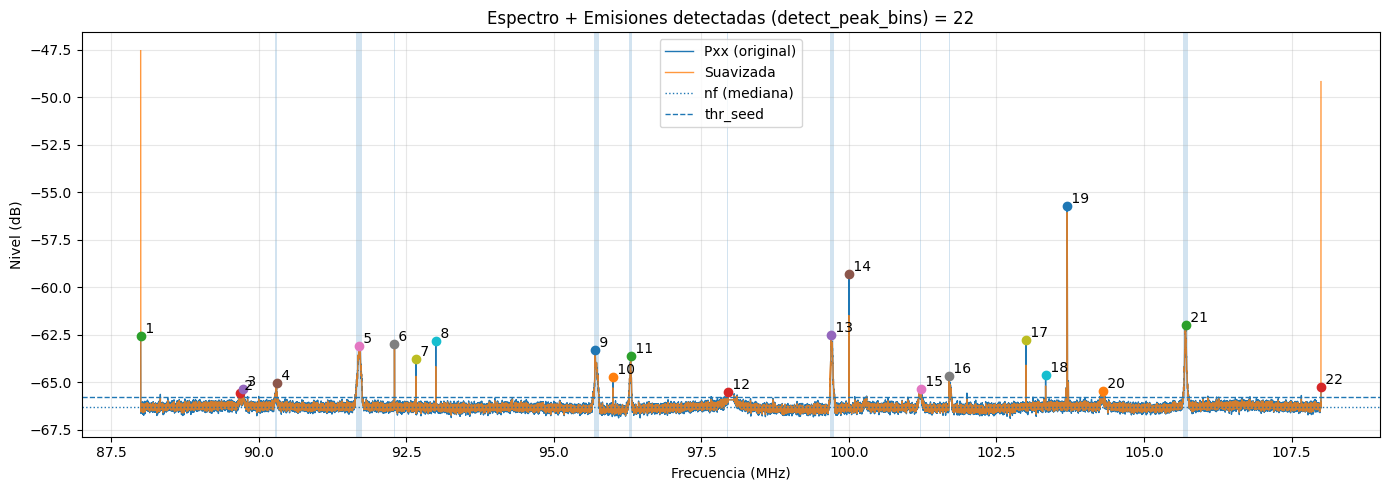

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

# =========================
# 1) Cargar JSON
# =========================
JSON_PATH = "D:\kl_psd\spectrum_camp-ane2-test3_medicion20_2025-12-16T16-11-57 (1).json"  # <-- cambia por el nombre real

with open(JSON_PATH, "r") as f:
    d = json.load(f)

pxx_db = np.asarray(d["Pxx"], dtype=float)
f_start = float(d["start_freq_hz"])
f_end   = float(d["end_freq_hz"])

N = len(pxx_db)
freq_hz = np.linspace(f_start, f_end, N, endpoint=False)

# =========================
# 2) Estructura SpectrumFrame
# =========================
@dataclass
class SpectrumFrame:
    amplitudes_dbm: np.ndarray
    freqs_hz: np.ndarray

frame = SpectrumFrame(amplitudes_dbm=pxx_db, freqs_hz=freq_hz)

# =========================
# 3) Estimadores robustos: NF y threshold
# =========================
def estimate_noise_floor(frame: SpectrumFrame) -> float:
    """
    Piso de ruido robusto: mediana (en dB).
    """
    x = np.asarray(frame.amplitudes_dbm, dtype=float)
    return float(np.median(x))

def adaptive_threshold(frame: SpectrumFrame, n_sigma: float = 3.5) -> float:
    """
    Umbral robusto: mediana + n_sigma * sigma_MAD
    """
    x = np.asarray(frame.amplitudes_dbm, dtype=float)
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    sigma = 1.4826 * mad
    return float(med + n_sigma * sigma)

# =========================
# 4) Tu algoritmo de detección de picos (adaptado)
# =========================
def detect_peak_bins(frame: SpectrumFrame) -> List[int]:
    """Localizar bins que funcionen como picos iniciales para análisis detallados."""
    y_dbm = np.asarray(frame.amplitudes_dbm, dtype=float)
    N = y_dbm.size

    # --- Suavizado ligero ---
    kernel = np.array([0.25, 0.5, 0.25], dtype=float)
    y_smooth = np.convolve(y_dbm, kernel, mode="same")

    # Piso de ruido (mediana) para referencia de SNR
    nf = estimate_noise_floor(frame)

    # --- Umbral de semilla ---
    try:
        thr_seed = adaptive_threshold(frame, n_sigma=3.5)
    except Exception:
        thr_seed = nf + 2.0

    # --- SNR mínimo ---
    min_snr_db = 0.73

    cand: List[int] = []

    # Recorremos segmentos donde y_smooth supera thr_seed
    i = 0
    while i < N:
        if y_smooth[i] > thr_seed:
            s = i
            while i < N and y_smooth[i] > thr_seed:
                i += 1
            e = i

            if e > s:
                seg = y_dbm[s:e]
                pk_local = int(np.argmax(seg) + s)
                amp = y_dbm[pk_local]

                if amp - nf >= min_snr_db:
                    cand.append(pk_local)
        else:
            i += 1

    if len(cand) <= 1:
        return sorted(cand)

    # --- No-maximum suppression ---
    cand = sorted(cand, key=lambda idx: y_dbm[idx], reverse=True)

    min_sep_bins = max(3, int(0.001 * N))

    kept: List[int] = []
    taken = np.zeros(N, dtype=np.bool_)
    for idx in cand:
        left = max(0, idx - min_sep_bins)
        right = min(N, idx + min_sep_bins)
        if not taken[left:right].any():
            kept.append(idx)
            taken[left:right] = True

    return sorted(kept)

# =========================
# 5) Extra: hallar segmento (s,e) para sombrear alrededor del pico
# =========================
def segment_bounds_from_threshold(y_smooth: np.ndarray, idx: int, thr_seed: float) -> Tuple[int, int]:
    N = len(y_smooth)
    l = idx
    while l > 0 and y_smooth[l] > thr_seed:
        l -= 1
    r = idx
    while r < N-1 and y_smooth[r] > thr_seed:
        r += 1
    return l, r

# =========================
# 6) Ejecutar detección
# =========================
nf = estimate_noise_floor(frame)
thr_seed = adaptive_threshold(frame, n_sigma=3.5)

kernel = np.array([0.25, 0.5, 0.25], dtype=float)
y_smooth = np.convolve(pxx_db, kernel, mode="same")

peaks = detect_peak_bins(frame)

print(f"Piso de ruido (nf, mediana): {nf:.3f} dB")
print(f"thr_seed (med + 3.5*sigma_MAD): {thr_seed:.3f} dB")
print(f"\n✅ Emisiones detectadas (picos finales): {len(peaks)}\n")

df_hz = (freq_hz[1] - freq_hz[0]) if N > 1 else 0.0

for k, idx in enumerate(peaks, 1):
    f_mhz = freq_hz[idx] / 1e6
    amp = pxx_db[idx]
    snr = amp - nf
    print(f"[{k}] bin={idx}, f={f_mhz:.6f} MHz, pico={amp:.2f} dB, SNR≈{snr:.2f} dB")

# =========================
# 7) Graficar + marcar emisiones
# =========================
plt.figure(figsize=(14, 5))
plt.plot(freq_hz/1e6, pxx_db, linewidth=1, label="Pxx (original)")
plt.plot(freq_hz/1e6, y_smooth, linewidth=1, alpha=0.8, label="Suavizada")

plt.axhline(nf, linestyle=":", linewidth=1, label="nf (mediana)")
plt.axhline(thr_seed, linestyle="--", linewidth=1, label="thr_seed")

# marcar picos y sombrear su segmento y_smooth > thr_seed
for k, idx in enumerate(peaks, 1):
    l, r = segment_bounds_from_threshold(y_smooth, idx, thr_seed)

    fs = freq_hz[l] / 1e6
    fe = freq_hz[r] / 1e6
    fc = freq_hz[idx] / 1e6
    pk = pxx_db[idx]

    plt.axvspan(fs, fe, alpha=0.2)
    plt.plot([fc], [pk], marker="o")
    plt.text(fc, pk, f" {k}", va="bottom")

plt.title(f"Espectro + Emisiones detectadas (detect_peak_bins) = {len(peaks)}")
plt.xlabel("Frecuencia (MHz)")
plt.ylabel("Nivel (dB)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


nf (piso, mediana): -66.302 dB
sigma (robusta, MAD): 0.156 dB
thr recomendado (nf + 3.5σ): -65.756 dB


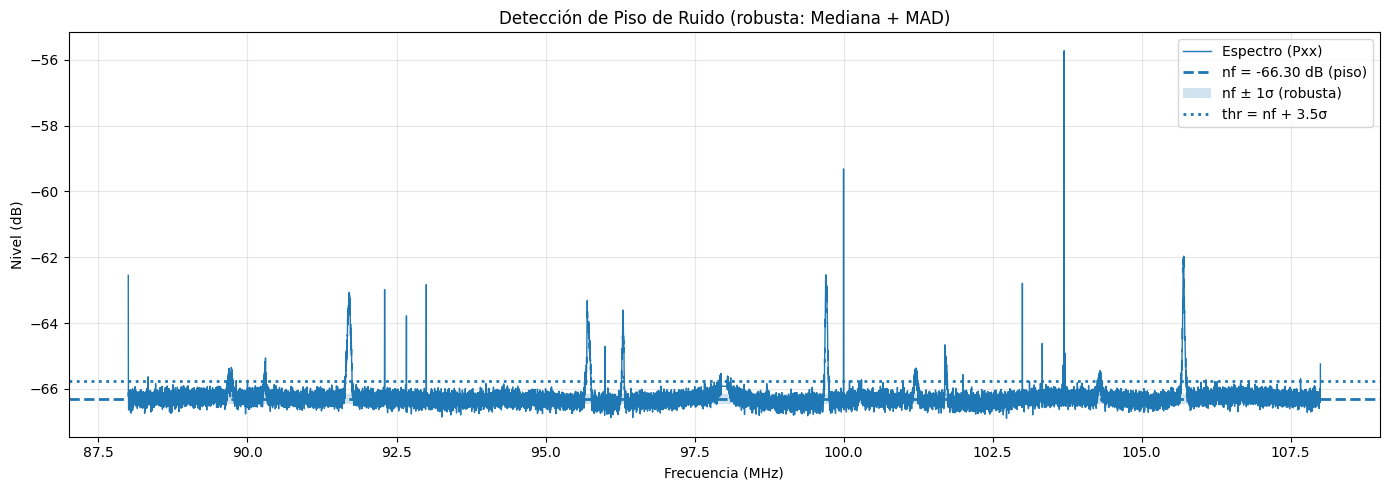

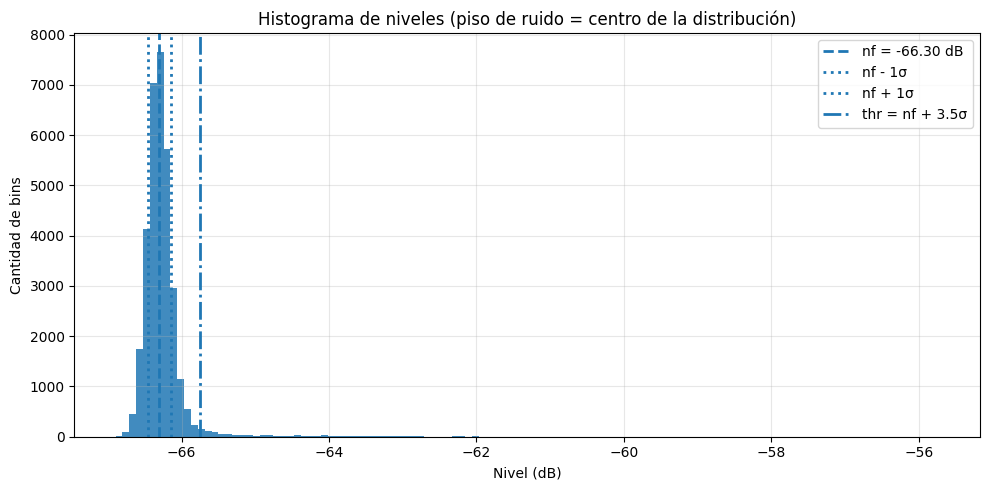

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1) Cargar JSON
# =========================
JSON_PATH = "D:\kl_psd\spectrum_camp-ane2-test3_medicion20_2025-12-16T16-11-57 (1).json"  # <-- cambia por el nombre real

with open(JSON_PATH, "r") as f:
    d = json.load(f)

pxx_db = np.asarray(d["Pxx"], dtype=float)
f_start = float(d["start_freq_hz"])
f_end   = float(d["end_freq_hz"])

N = len(pxx_db)
freq_mhz = np.linspace(f_start, f_end, N, endpoint=False) / 1e6

# =========================
# 2) Estimación robusta del piso de ruido (mediana + MAD)
# =========================
def noise_floor_mad(x_db: np.ndarray):
    x = np.asarray(x_db, dtype=float)
    med = np.median(x)  # piso (robusto)
    mad = np.median(np.abs(x - med)) + 1e-12
    sigma = 1.4826 * mad  # sigma equivalente robusta
    return float(med), float(sigma)

nf, sigma = noise_floor_mad(pxx_db)

# Umbral recomendado (solo para referencia visual)
k = 3.5
thr = nf + k * sigma

print(f"nf (piso, mediana): {nf:.3f} dB")
print(f"sigma (robusta, MAD): {sigma:.3f} dB")
print(f"thr recomendado (nf + {k}σ): {thr:.3f} dB")

# =========================
# 3) Gráfica 1: espectro + piso + banda
# =========================
plt.figure(figsize=(14, 5))
plt.plot(freq_mhz, pxx_db, linewidth=1, label="Espectro (Pxx)")

# Piso y banda
plt.axhline(nf, linestyle="--", linewidth=2, label=f"nf = {nf:.2f} dB (piso)")
plt.fill_between(freq_mhz, nf - sigma, nf + sigma, alpha=0.2, label="nf ± 1σ (robusta)")
plt.axhline(thr, linestyle=":", linewidth=2, label=f"thr = nf + {k}σ")

plt.title("Detección de Piso de Ruido (robusta: Mediana + MAD)")
plt.xlabel("Frecuencia (MHz)")
plt.ylabel("Nivel (dB)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 4) Gráfica 2: histograma + líneas (MUY fácil de leer)
# =========================
plt.figure(figsize=(10, 5))
plt.hist(pxx_db, bins=120, alpha=0.85)

plt.axvline(nf, linestyle="--", linewidth=2, label=f"nf = {nf:.2f} dB")
plt.axvline(nf - sigma, linestyle=":", linewidth=2, label="nf - 1σ")
plt.axvline(nf + sigma, linestyle=":", linewidth=2, label="nf + 1σ")
plt.axvline(thr, linestyle="-.", linewidth=2, label=f"thr = nf + {k}σ")

plt.title("Histograma de niveles (piso de ruido = centro de la distribución)")
plt.xlabel("Nivel (dB)")
plt.ylabel("Cantidad de bins")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


=== Pisos estimados (dB/dBm) ===
simple_modeWinMean: -66.265   (Δ vs MAD = +0.037 dB)
median          : -66.302   (Δ vs MAD = +0.000 dB)
percentile_25   : -66.404   (Δ vs MAD = -0.101 dB)
hist_mode       : -66.309   (Δ vs MAD = -0.007 dB)
irls_tstudent   : -66.301   (Δ vs MAD = +0.001 dB)
mad_median      : -66.302   (Δ vs MAD = +0.000 dB)
mad_sigma       :  0.156
thr_mad_plus_3.5sigma: -65.756


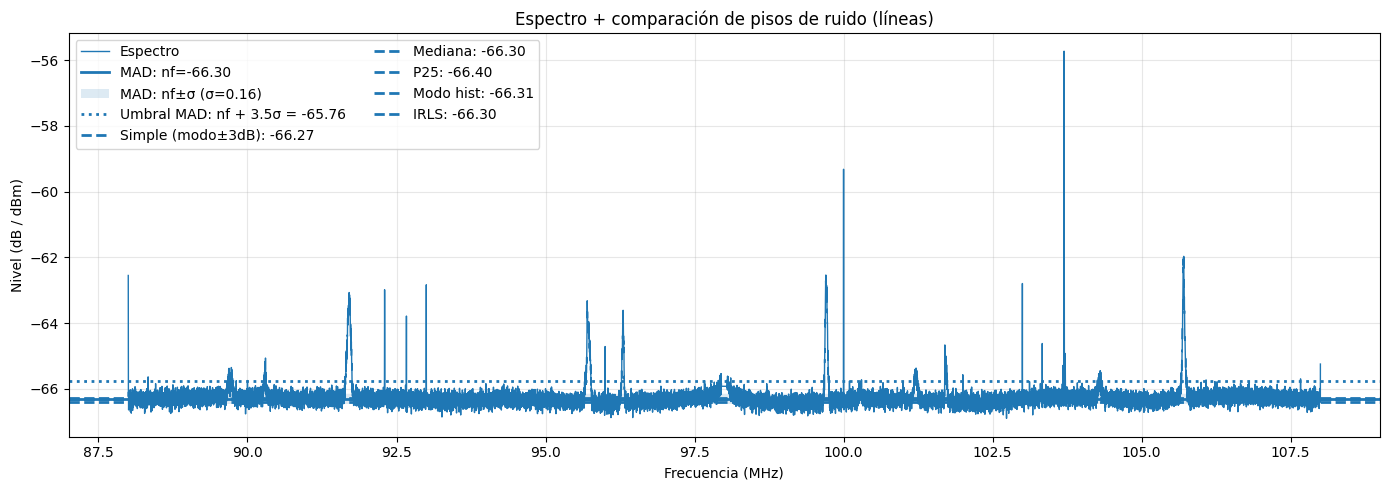

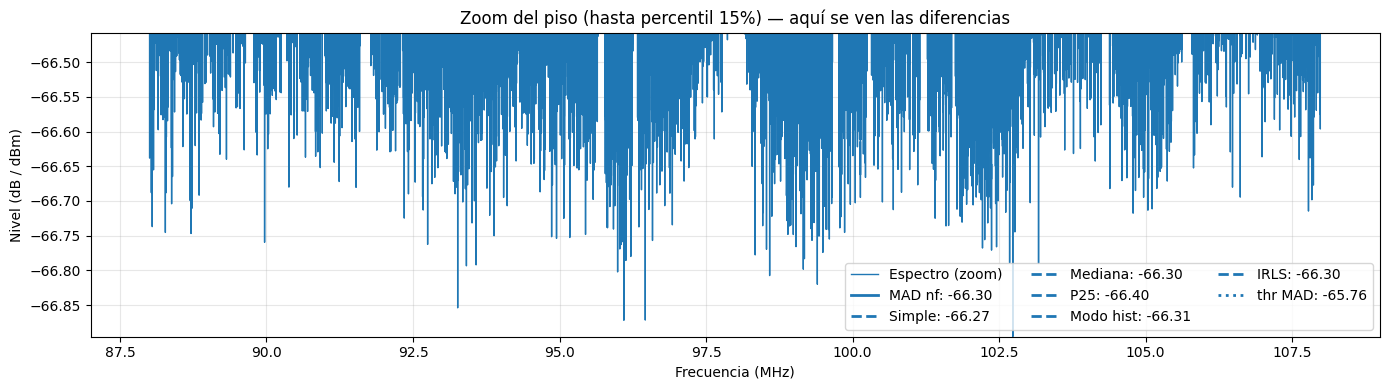

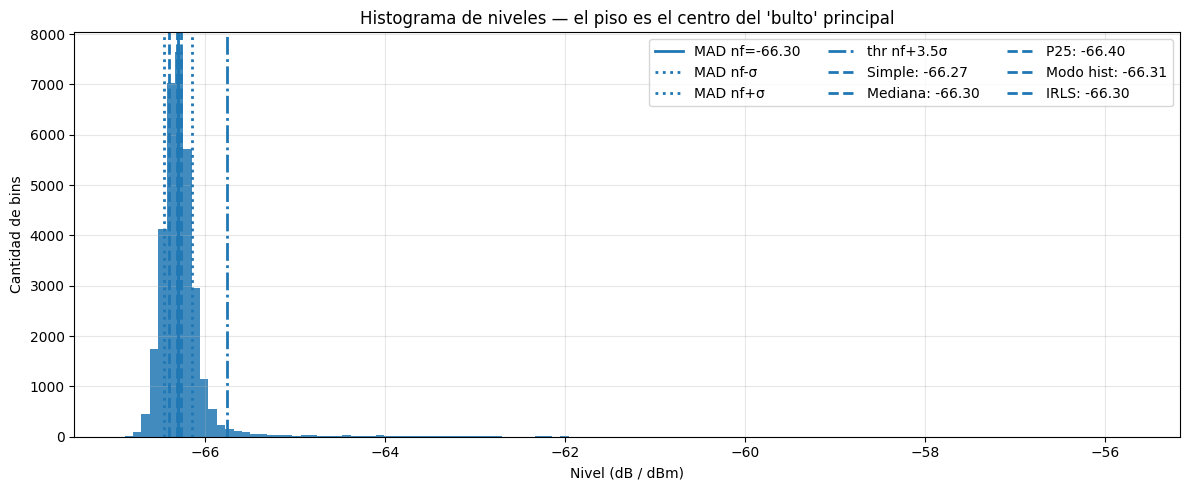

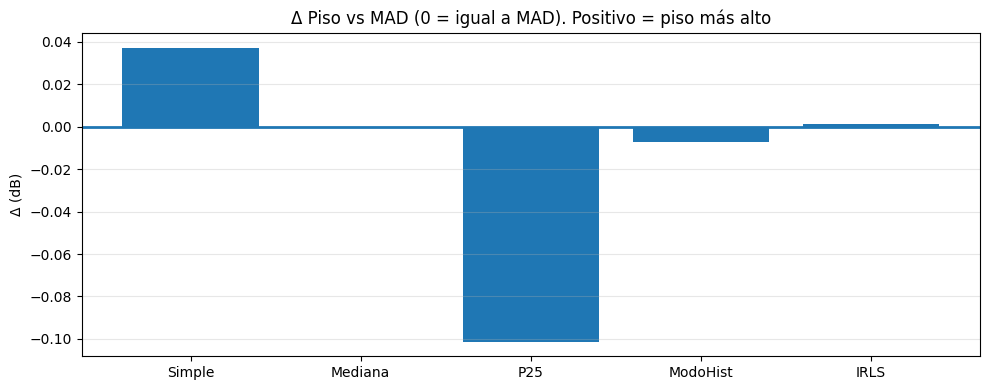

In [4]:
# =========================================================
# PISO DE RUIDO (varios métodos) + GRÁFICAS INTUITIVAS
# - Carga JSON (Pxx + start/end freq)
# - Construye SpectrumFrame
# - Compara pisos: simple(modo±3dB), mediana, P25, modo-hist, IRLS, MAD(+sigma)
# - Grafica: espectro full, zoom del piso, histograma, barras Δ vs MAD
# =========================================================

import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Tuple

# =========================
# 0) Ruta del JSON
# =========================
JSON_PATH = "D:\kl_psd\spectrum_camp-ane2-test3_medicion20_2025-12-16T16-11-57 (1).json"  # <-- cambia aquí

# =========================
# 1) Cargar JSON
# =========================
with open(JSON_PATH, "r") as f:
    d = json.load(f)

pxx_db = np.asarray(d["Pxx"], dtype=float)
f_start = float(d["start_freq_hz"])
f_end   = float(d["end_freq_hz"])

N = len(pxx_db)
freq_hz = np.linspace(f_start, f_end, N, endpoint=False)  # eje en Hz

# =========================================================
# 2) SpectrumFrame (mínimo)
# =========================================================
@dataclass
class SpectrumFrame:
    amplitudes_dbm: np.ndarray
    freqs_hz: Optional[np.ndarray] = None

# =========================================================
# 3) Estimadores de piso de ruido
# =========================================================
def _hist_mode(x: np.ndarray, bins: int) -> float:
    counts, edges = np.histogram(x, bins=bins)
    i = int(np.argmax(counts))
    return float((edges[i] + edges[i+1]) / 2.0)

def estimate_noise_floor_simple(frame: SpectrumFrame, win_db: float = 6.0,
                                min_points: int = 8) -> float:
    """
    Piso simple:
    - Moda por histograma
    - Ventana +/- win_db/2 alrededor del modo
    - Si hay suficientes puntos dentro => media dentro de ventana
    - Si no => mediana global
    """
    x = np.asarray(frame.amplitudes_dbm, dtype=float)
    bins = min(256, max(32, int(np.sqrt(x.size))))
    mode = _hist_mode(x, bins=bins)

    mask = (x >= mode - win_db/2) & (x <= mode + win_db/2)
    if int(mask.sum()) >= int(min_points):
        return float(x[mask].mean())
    return float(np.median(x))

def estimate_noise_floor_robust(frame: SpectrumFrame, method: str = "median") -> float:
    x = np.asarray(frame.amplitudes_dbm, dtype=float)
    m = (method or "median").lower()

    if m == "median":
        return float(np.median(x))

    if m == "percentile":
        return float(np.percentile(x, 25.0))

    if m == "histogram":
        bins = min(256, max(32, int(np.sqrt(x.size))))
        return float(_hist_mode(x, bins=bins))

    # Fallback: IRLS t-Student (robusto a colas/picos)
    mu = float(np.median(x))
    r = x - mu
    mad = np.median(np.abs(r)) + 1e-12
    sigma2 = float((1.4826 * mad) ** 2)

    nu = 6.0
    tol = 1e-5
    itmax = 50

    for _ in range(itmax):
        tval = (r * r) / max(sigma2, 1e-18)
        w = (nu + 1.0) / (nu + tval)
        wsum = float(np.sum(w) + 1e-18)
        mu_new = float(np.sum(w * x) / wsum)

        r = x - mu_new
        tval = (r * r) / max(sigma2, 1e-18)
        w = (nu + 1.0) / (nu + tval)
        wsum = float(np.sum(w) + 1e-18)
        sigma2_new = float(np.sum(w * r * r) / wsum)

        if (abs(mu_new - mu) <= tol * (abs(mu) + 1e-12)) and \
           (abs(sigma2_new - sigma2) <= tol * (sigma2 + 1e-12)):
            mu, sigma2 = mu_new, max(1e-18, sigma2_new)
            break

        mu, sigma2 = mu_new, max(1e-18, sigma2_new)

    return float(mu)

def noise_floor_mad_sigma(x_db: np.ndarray) -> Tuple[float, float]:
    """
    Devuelve:
      nf = mediana
      sigma = 1.4826*MAD (robusto)  en dB
    """
    x = np.asarray(x_db, dtype=float)
    med = float(np.median(x))
    mad = float(np.median(np.abs(x - med)) + 1e-12)
    sigma = float(1.4826 * mad)
    return med, sigma

# =========================================================
# 4) Comparador + gráficos (INTUITIVO)
# =========================================================
def compare_noise_floors_and_plot_intuitive(
    frame: SpectrumFrame,
    k_sigma: float = 3.5,
    hist_bins: int = 120,
    show_zoom_percent: float = 15.0,
) -> Dict[str, float]:

    x = np.asarray(frame.amplitudes_dbm, dtype=float)

    # Eje
    if frame.freqs_hz is not None:
        fx = np.asarray(frame.freqs_hz, dtype=float) / 1e6
        xlab = "Frecuencia (MHz)"
    else:
        fx = np.arange(x.size)
        xlab = "Bin"

    # Pisos
    nf_simple = estimate_noise_floor_simple(frame, win_db=6.0, min_points=8)
    nf_med    = estimate_noise_floor_robust(frame, "median")
    nf_p25    = estimate_noise_floor_robust(frame, "percentile")
    nf_hist   = estimate_noise_floor_robust(frame, "histogram")
    nf_irls   = estimate_noise_floor_robust(frame, "irls")  # cae al fallback IRLS

    # MAD (referencia)
    nf_mad, sigma = noise_floor_mad_sigma(x)
    thr_mad = nf_mad + k_sigma * sigma

    floors = {
        "simple_modeWinMean": float(nf_simple),
        "median": float(nf_med),
        "percentile_25": float(nf_p25),
        "hist_mode": float(nf_hist),
        "irls_tstudent": float(nf_irls),
        "mad_median": float(nf_mad),
        "mad_sigma": float(sigma),
        f"thr_mad_plus_{k_sigma}sigma": float(thr_mad),
    }

    # ---- Print resumen con deltas vs MAD ----
    print("\n=== Pisos estimados (dB/dBm) ===")
    ref = nf_mad
    for k in ["simple_modeWinMean", "median", "percentile_25", "hist_mode", "irls_tstudent", "mad_median"]:
        v = floors[k]
        print(f"{k:16s}: {v: .3f}   (Δ vs MAD = {v-ref:+.3f} dB)")
    print(f"{'mad_sigma':16s}: {floors['mad_sigma']: .3f}")
    print(f"{f'thr_mad_plus_{k_sigma}sigma':16s}: {floors[f'thr_mad_plus_{k_sigma}sigma']: .3f}")

    # ---- Plot 1: espectro full + líneas ----
    plt.figure(figsize=(14, 5))
    plt.plot(fx, x, linewidth=1, label="Espectro")

    plt.axhline(nf_mad, linestyle="-", linewidth=2, label=f"MAD: nf={nf_mad:.2f}")
    plt.fill_between(fx, nf_mad - sigma, nf_mad + sigma, alpha=0.15, label=f"MAD: nf±σ (σ={sigma:.2f})")
    plt.axhline(thr_mad, linestyle=":", linewidth=2, label=f"Umbral MAD: nf + {k_sigma}σ = {thr_mad:.2f}")

    plt.axhline(nf_simple, linestyle="--", linewidth=2, label=f"Simple (modo±3dB): {nf_simple:.2f}")
    plt.axhline(nf_med,    linestyle="--", linewidth=2, label=f"Mediana: {nf_med:.2f}")
    plt.axhline(nf_p25,    linestyle="--", linewidth=2, label=f"P25: {nf_p25:.2f}")
    plt.axhline(nf_hist,   linestyle="--", linewidth=2, label=f"Modo hist: {nf_hist:.2f}")
    plt.axhline(nf_irls,   linestyle="--", linewidth=2, label=f"IRLS: {nf_irls:.2f}")

    plt.title("Espectro + comparación de pisos de ruido (líneas)")
    plt.xlabel(xlab)
    plt.ylabel("Nivel (dB / dBm)")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # ---- Plot 2: zoom del piso (para ver diferencias) ----
    y_min = np.percentile(x, 0.0)
    y_max = np.percentile(x, show_zoom_percent)

    plt.figure(figsize=(14, 4))
    plt.plot(fx, x, linewidth=1, label="Espectro (zoom)")
    plt.ylim(y_min, y_max)

    for name, val in [
        ("MAD nf", nf_mad),
        ("Simple", nf_simple),
        ("Mediana", nf_med),
        ("P25", nf_p25),
        ("Modo hist", nf_hist),
        ("IRLS", nf_irls),
        ("thr MAD", thr_mad),
    ]:
        ls = "-" if name == "MAD nf" else (":" if "thr" in name else "--")
        plt.axhline(val, linestyle=ls, linewidth=2, label=f"{name}: {val:.2f}")

    plt.title(f"Zoom del piso (hasta percentil {show_zoom_percent:.0f}%) — aquí se ven las diferencias")
    plt.xlabel(xlab)
    plt.ylabel("Nivel (dB / dBm)")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=3)
    plt.tight_layout()
    plt.show()

    # ---- Plot 3: histograma (más intuitivo para piso) ----
    plt.figure(figsize=(12, 5))
    plt.hist(x, bins=hist_bins, alpha=0.85)

    plt.axvline(nf_mad, linestyle="-", linewidth=2, label=f"MAD nf={nf_mad:.2f}")
    plt.axvline(nf_mad - sigma, linestyle=":", linewidth=2, label="MAD nf-σ")
    plt.axvline(nf_mad + sigma, linestyle=":", linewidth=2, label="MAD nf+σ")
    plt.axvline(thr_mad, linestyle="-.", linewidth=2, label=f"thr nf+{k_sigma}σ")

    for name, val in [
        ("Simple", nf_simple),
        ("Mediana", nf_med),
        ("P25", nf_p25),
        ("Modo hist", nf_hist),
        ("IRLS", nf_irls),
    ]:
        plt.axvline(val, linestyle="--", linewidth=2, label=f"{name}: {val:.2f}")

    plt.title("Histograma de niveles — el piso es el centro del 'bulto' principal")
    plt.xlabel("Nivel (dB / dBm)")
    plt.ylabel("Cantidad de bins")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=3)
    plt.tight_layout()
    plt.show()

    # ---- Plot 4: diferencias Δ vs MAD (bar chart) ----
    labels = ["Simple", "Mediana", "P25", "ModoHist", "IRLS"]
    vals   = [nf_simple, nf_med, nf_p25, nf_hist, nf_irls]
    deltas = [v - nf_mad for v in vals]

    plt.figure(figsize=(10, 4))
    plt.bar(labels, deltas)
    plt.axhline(0.0, linewidth=2)
    plt.title("Δ Piso vs MAD (0 = igual a MAD). Positivo = piso más alto")
    plt.ylabel("Δ (dB)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return floors

# =========================================================
# 5) Ejecutar comparación
# =========================================================
frame = SpectrumFrame(amplitudes_dbm=pxx_db, freqs_hz=freq_hz)
floors = compare_noise_floors_and_plot_intuitive(frame, k_sigma=3.5, hist_bins=120, show_zoom_percent=15.0)


=== GLOBAL noise floor (métodos del documento) ===
simple_modeWinMean: -66.265   (Δ vs MAD = +0.037 dB)
median            : -66.302   (Δ vs MAD = +0.000 dB)
percentile_25     : -66.404   (Δ vs MAD = -0.101 dB)
hist_mode         : -66.309   (Δ vs MAD = -0.007 dB)
irls_tstudent     : -66.301   (Δ vs MAD = +0.001 dB)
fcme_noise_floor  : -66.278   (Δ vs MAD = +0.024 dB)
mad_median        : -66.302   (Δ vs MAD = +0.000 dB)
mad_sigma         :  0.156
thr_mad_plus_3.5sigma: -65.756
FCME details: alpha=1.5, m0=3276, m_final=32402


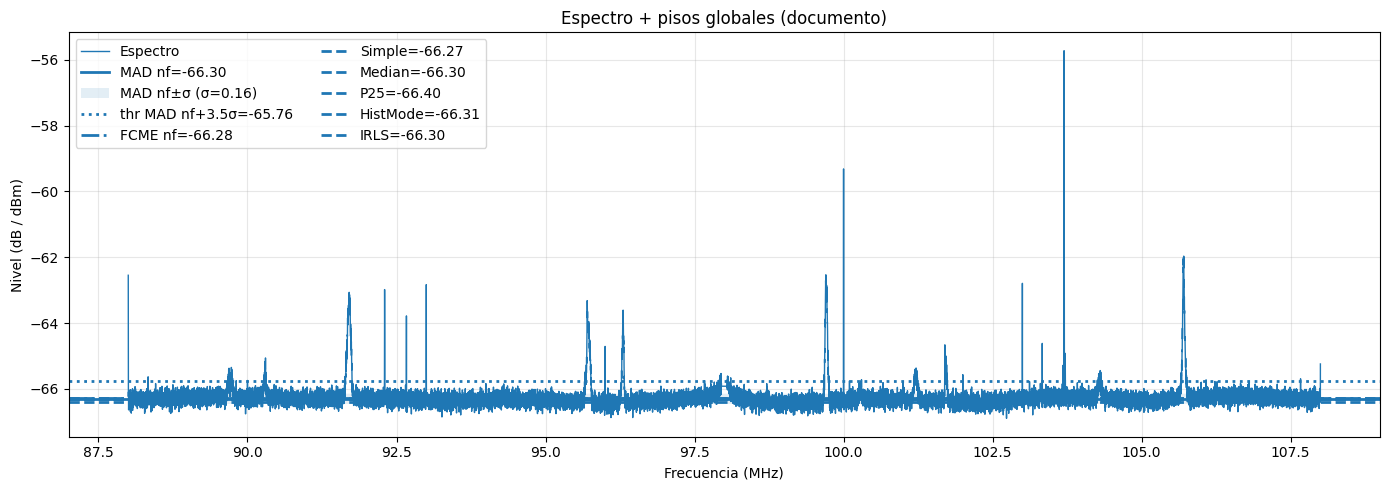

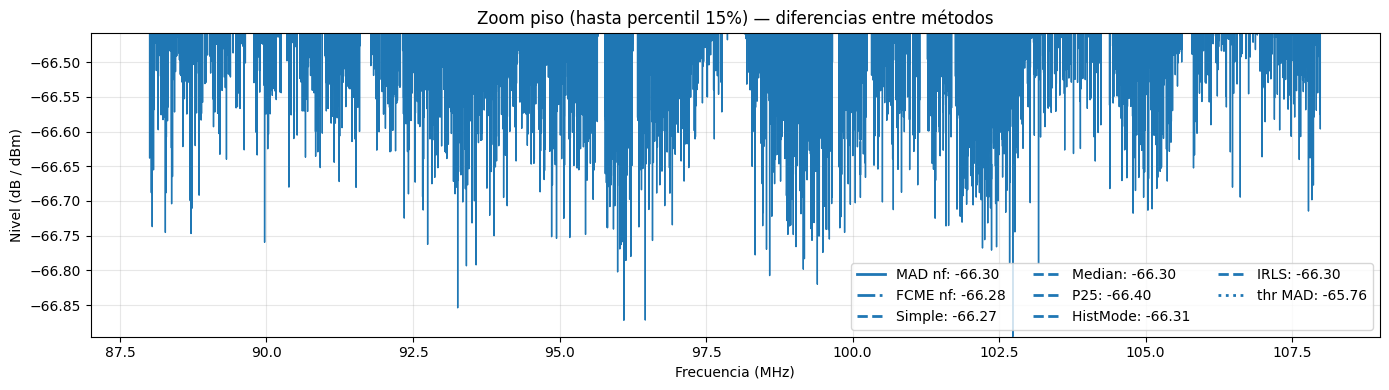

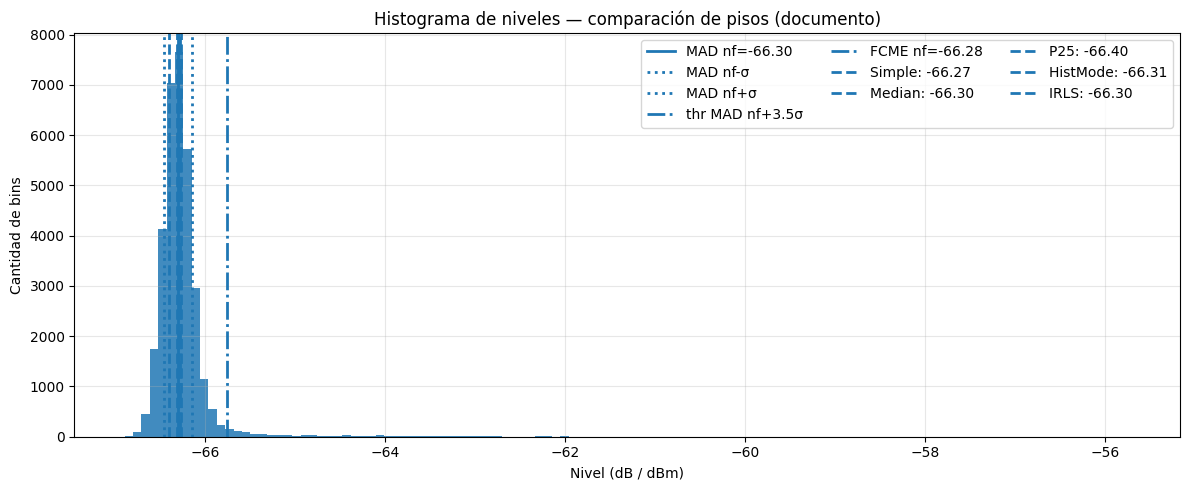

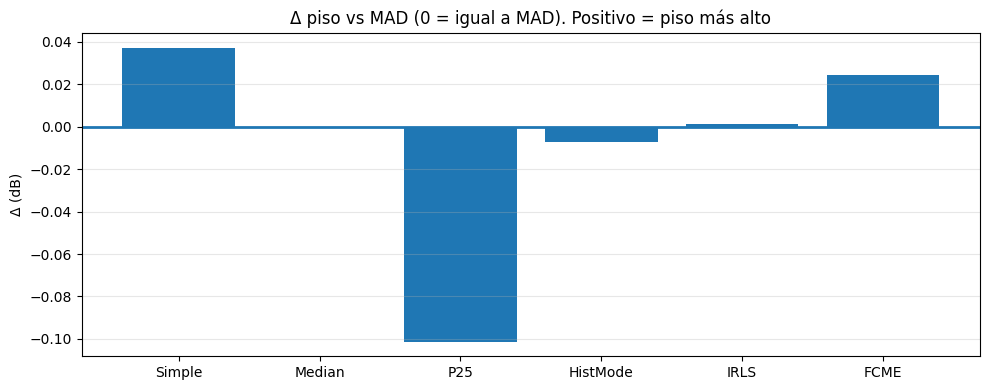

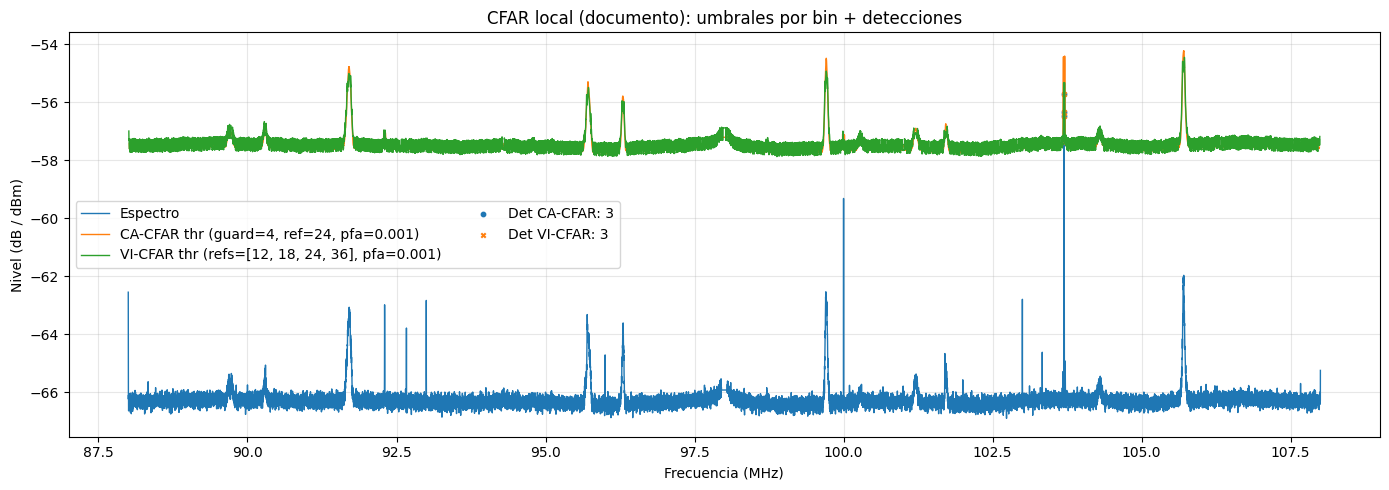


=== DONE ===
Keys in floors: ['simple_modeWinMean', 'median', 'percentile_25', 'hist_mode', 'irls_tstudent', 'mad_median', 'mad_sigma', 'thr_mad_plus_3.5sigma', 'fcme_noise_floor', 'cfar_ca_num_detections', 'cfar_vi_num_detections']


In [5]:
# =========================================================
# NOISE FLOOR — TODOS los métodos del documento + gráficas
# - Carga JSON (Pxx + start/end freq)
# - Calcula estimadores globales (median, percentile, hist, MAD, IRLS, FCME, simple)
# - Calcula estimadores LOCALES tipo CFAR (CA-CFAR y VI-CFAR aprox)
# - Calcula seguimiento EMA si hay múltiples frames (opcional)
# - Gráficas: espectro + líneas, zoom del piso, histograma, deltas vs referencia,
#             y mapas CFAR (umbral y detecciones)
# =========================================================

import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Tuple

# =========================
# 0) Ruta del JSON
# =========================
JSON_PATH = "D:\kl_psd\spectrum_camp-ane2-test3_medicion20_2025-12-16T16-11-57 (1).json"  # <-- cambia aquí

# =========================
# 1) Cargar JSON
# =========================
with open(JSON_PATH, "r") as f:
    d = json.load(f)

# PSD principal (1 frame)
pxx_db = np.asarray(d["Pxx"], dtype=float)
f_start = float(d["start_freq_hz"])
f_end   = float(d["end_freq_hz"])
N = len(pxx_db)
freq_hz = np.linspace(f_start, f_end, N, endpoint=False)

# =========================================================
# 2) SpectrumFrame (mínimo)
# =========================================================
@dataclass
class SpectrumFrame:
    amplitudes_dbm: np.ndarray
    freqs_hz: Optional[np.ndarray] = None

# =========================================================
# 3) Helpers
# =========================================================
def db_to_lin_power(x_db: np.ndarray) -> np.ndarray:
    # Asume que x_db representa potencia en dB (10log10(P)).
    return 10.0 ** (np.asarray(x_db, dtype=float) / 10.0)

def lin_power_to_db(p: np.ndarray, eps: float = 1e-30) -> np.ndarray:
    return 10.0 * np.log10(np.maximum(np.asarray(p, dtype=float), eps))

def _hist_mode(x: np.ndarray, bins: int) -> float:
    counts, edges = np.histogram(x, bins=bins)
    i = int(np.argmax(counts))
    return float((edges[i] + edges[i+1]) / 2.0)

# =========================================================
# 4) Estimadores globales (noise floor)
# =========================================================
def estimate_noise_floor_simple(frame: SpectrumFrame, win_db: float = 6.0, min_points: int = 8) -> float:
    x = np.asarray(frame.amplitudes_dbm, dtype=float)
    bins = min(256, max(32, int(np.sqrt(x.size))))
    mode = _hist_mode(x, bins=bins)

    mask = (x >= mode - win_db/2) & (x <= mode + win_db/2)
    if int(mask.sum()) >= int(min_points):
        return float(x[mask].mean())
    return float(np.median(x))

def estimate_noise_floor_median(frame: SpectrumFrame) -> float:
    x = np.asarray(frame.amplitudes_dbm, dtype=float)
    return float(np.median(x))

def estimate_noise_floor_percentile(frame: SpectrumFrame, p: float = 25.0) -> float:
    x = np.asarray(frame.amplitudes_dbm, dtype=float)
    return float(np.percentile(x, p))

def estimate_noise_floor_hist_mode(frame: SpectrumFrame) -> float:
    x = np.asarray(frame.amplitudes_dbm, dtype=float)
    bins = min(256, max(32, int(np.sqrt(x.size))))
    return float(_hist_mode(x, bins=bins))

def noise_floor_mad_sigma(x_db: np.ndarray) -> Tuple[float, float]:
    x = np.asarray(x_db, dtype=float)
    med = float(np.median(x))
    mad = float(np.median(np.abs(x - med)) + 1e-12)
    sigma = float(1.4826 * mad)
    return med, sigma

def estimate_noise_floor_irls_tstudent(frame: SpectrumFrame, nu: float = 6.0, itmax: int = 50, tol: float = 1e-5) -> float:
    x = np.asarray(frame.amplitudes_dbm, dtype=float)
    mu = float(np.median(x))
    r = x - mu
    mad = np.median(np.abs(r)) + 1e-12
    sigma2 = float((1.4826 * mad) ** 2)

    for _ in range(itmax):
        tval = (r * r) / max(sigma2, 1e-18)
        w = (nu + 1.0) / (nu + tval)
        wsum = float(np.sum(w) + 1e-18)
        mu_new = float(np.sum(w * x) / wsum)

        r = x - mu_new
        tval = (r * r) / max(sigma2, 1e-18)
        w = (nu + 1.0) / (nu + tval)
        wsum = float(np.sum(w) + 1e-18)
        sigma2_new = float(np.sum(w * r * r) / wsum)

        if (abs(mu_new - mu) <= tol * (abs(mu) + 1e-12)) and (abs(sigma2_new - sigma2) <= tol * (sigma2 + 1e-12)):
            mu, sigma2 = mu_new, max(1e-18, sigma2_new)
            break
        mu, sigma2 = mu_new, max(1e-18, sigma2_new)

    return float(mu)

# =========================================================
# 5) FCME (Forward Consecutive Mean Excision)
#    Implementación en dominio de potencia lineal (recomendado)
# =========================================================
def estimate_noise_floor_fcme(x_db: np.ndarray, alpha: float = 1.5, m0: Optional[int] = None) -> Tuple[float, Dict]:
    """
    FCME:
    - Ordena potencias lineales ascendente
    - Arranca con m0 bins más bajos (ruido provisional)
    - Itera: mu = mean(noise_set), incluye consecutivos mientras X <= alpha*mu
    - Retorna mu_final (en dB) y detalles
    """
    x_db = np.asarray(x_db, dtype=float)
    x_lin = db_to_lin_power(x_db)

    xs = np.sort(x_lin)
    N = xs.size
    if m0 is None:
        # inicio típico: 10% de bins, mínimo 16
        m0 = max(16, int(0.10 * N))
    m0 = int(np.clip(m0, 8, N))

    # Conjunto inicial
    m = m0
    mu = float(np.mean(xs[:m]))

    # Crece de manera consecutiva
    while m < N:
        if xs[m] <= alpha * mu:
            m += 1
            mu = float(np.mean(xs[:m]))
        else:
            break

    nf_db = float(lin_power_to_db(mu))
    details = {"alpha": alpha, "m0": m0, "m_final": m, "mu_lin": mu}
    return nf_db, details

# =========================================================
# 6) CFAR en frecuencia (CA-CFAR) — estimación local por bin
# =========================================================
def ca_cfar_threshold(x_db: np.ndarray, guard: int = 4, ref: int = 24, pfa: float = 1e-3) -> np.ndarray:
    """
    CA-CFAR (Cell Averaging CFAR) sobre potencia lineal:
    - Para cada CUT k, usa referencias a izquierda y derecha (excluye guard cells)
    - Estima ruido = mean(ref_cells)
    - Umbral = alpha * ruido, donde alpha depende de pfa y #ref
      alpha = Nref * (pfa^(-1/Nref) - 1)
    Retorna umbral en dB por bin.
    """
    x_lin = db_to_lin_power(np.asarray(x_db, dtype=float))
    N = x_lin.size
    thr_lin = np.full(N, np.nan, dtype=float)

    Nref = 2 * ref
    alpha = Nref * (pfa ** (-1.0 / Nref) - 1.0)

    for k in range(N):
        l0 = k - guard - ref
        l1 = k - guard
        r0 = k + guard + 1
        r1 = k + guard + 1 + ref

        if l0 < 0 or r1 > N:
            continue

        ref_cells = np.concatenate([x_lin[l0:l1], x_lin[r0:r1]])
        noise = float(np.mean(ref_cells))
        thr_lin[k] = alpha * noise

    return lin_power_to_db(thr_lin)

# =========================================================
# 7) VI-CFAR (aprox) — selecciona ventana local “más limpia”
#    Idea: para cada CUT, prueba varios tamaños de ref y elige el que minimiza
#    la estimación de ruido (evita ventanas contaminadas por señales).
# =========================================================
def vi_cfar_threshold(x_db: np.ndarray, guard: int = 4,
                      ref_candidates=(12, 18, 24, 36),
                      pfa: float = 1e-3) -> np.ndarray:
    x_lin = db_to_lin_power(np.asarray(x_db, dtype=float))
    N = x_lin.size
    thr_lin = np.full(N, np.nan, dtype=float)

    for k in range(N):
        best_noise = None
        best_thr = None

        for ref in ref_candidates:
            Nref = 2 * ref
            alpha = Nref * (pfa ** (-1.0 / Nref) - 1.0)

            l0 = k - guard - ref
            l1 = k - guard
            r0 = k + guard + 1
            r1 = k + guard + 1 + ref
            if l0 < 0 or r1 > N:
                continue

            ref_cells = np.concatenate([x_lin[l0:l1], x_lin[r0:r1]])
            noise = float(np.mean(ref_cells))

            # criterio VI: escoger la ventana con menor "ruido" estimado
            # (tiende a evitar ventanas contaminadas por señales fuertes)
            if (best_noise is None) or (noise < best_noise):
                best_noise = noise
                best_thr = alpha * noise

        if best_thr is not None:
            thr_lin[k] = best_thr

    return lin_power_to_db(thr_lin)

# =========================================================
# 8) EMA Noise Floor Tracking (si hay múltiples frames)
#    Si no existen, lo deja como N/A.
# =========================================================
def ema_track_noise_floor(nf_inst_db: np.ndarray, alpha: float = 0.2) -> np.ndarray:
    nf_inst_db = np.asarray(nf_inst_db, dtype=float)
    out = np.empty_like(nf_inst_db)
    out[0] = nf_inst_db[0]
    for i in range(1, len(out)):
        out[i] = alpha * nf_inst_db[i] + (1 - alpha) * out[i-1]
    return out

# =========================================================
# 9) Comparación + gráficos
# =========================================================
def run_all_document_methods_and_plot(
    frame: SpectrumFrame,
    k_sigma: float = 3.5,
    hist_bins: int = 120,
    show_zoom_percent: float = 15.0,
    # CFAR params
    cfar_guard: int = 4,
    cfar_ref: int = 24,
    cfar_pfa: float = 1e-3,
    vi_ref_candidates=(12, 18, 24, 36),
    # FCME params
    fcme_alpha: float = 1.5,
) -> Dict[str, float]:

    x = np.asarray(frame.amplitudes_dbm, dtype=float)

    # Eje
    if frame.freqs_hz is not None:
        fx = np.asarray(frame.freqs_hz, dtype=float) / 1e6
        xlab = "Frecuencia (MHz)"
    else:
        fx = np.arange(x.size)
        xlab = "Bin"

    # ---- Global floors ----
    nf_simple = estimate_noise_floor_simple(frame)
    nf_med    = estimate_noise_floor_median(frame)
    nf_p25    = estimate_noise_floor_percentile(frame, 25.0)
    nf_hist   = estimate_noise_floor_hist_mode(frame)
    nf_irls   = estimate_noise_floor_irls_tstudent(frame)
    nf_mad, sigma = noise_floor_mad_sigma(x)
    thr_mad = nf_mad + k_sigma * sigma
    nf_fcme, fcme_info = estimate_noise_floor_fcme(x, alpha=fcme_alpha)

    floors = {
        "simple_modeWinMean": float(nf_simple),
        "median": float(nf_med),
        "percentile_25": float(nf_p25),
        "hist_mode": float(nf_hist),
        "irls_tstudent": float(nf_irls),
        "mad_median": float(nf_mad),
        "mad_sigma": float(sigma),
        f"thr_mad_plus_{k_sigma}sigma": float(thr_mad),
        "fcme_noise_floor": float(nf_fcme),
    }

    print("\n=== GLOBAL noise floor (métodos del documento) ===")
    ref = nf_mad
    order = ["simple_modeWinMean", "median", "percentile_25", "hist_mode", "irls_tstudent", "fcme_noise_floor", "mad_median"]
    for k in order:
        v = floors[k]
        print(f"{k:18s}: {v: .3f}   (Δ vs MAD = {v-ref:+.3f} dB)")
    print(f"{'mad_sigma':18s}: {floors['mad_sigma']: .3f}")
    print(f"{f'thr_mad_plus_{k_sigma}sigma':18s}: {floors[f'thr_mad_plus_{k_sigma}sigma']: .3f}")
    print(f"FCME details: alpha={fcme_info['alpha']}, m0={fcme_info['m0']}, m_final={fcme_info['m_final']}")

    # ---- CFAR local thresholds (documento) ----
    thr_ca = ca_cfar_threshold(x, guard=cfar_guard, ref=cfar_ref, pfa=cfar_pfa)
    thr_vi = vi_cfar_threshold(x, guard=cfar_guard, ref_candidates=vi_ref_candidates, pfa=cfar_pfa)

    # Detecciones tipo CFAR (solo donde hay umbral definido)
    det_ca = np.zeros_like(x, dtype=bool)
    m_ca = np.isfinite(thr_ca)
    det_ca[m_ca] = x[m_ca] > thr_ca[m_ca]

    det_vi = np.zeros_like(x, dtype=bool)
    m_vi = np.isfinite(thr_vi)
    det_vi[m_vi] = x[m_vi] > thr_vi[m_vi]

    # =========================================================
    # Plot 1: Espectro + pisos globales
    # =========================================================
    plt.figure(figsize=(14, 5))
    plt.plot(fx, x, linewidth=1, label="Espectro")

    plt.axhline(nf_mad, linestyle="-", linewidth=2, label=f"MAD nf={nf_mad:.2f}")
    plt.fill_between(fx, nf_mad - sigma, nf_mad + sigma, alpha=0.12, label=f"MAD nf±σ (σ={sigma:.2f})")
    plt.axhline(thr_mad, linestyle=":", linewidth=2, label=f"thr MAD nf+{k_sigma}σ={thr_mad:.2f}")

    plt.axhline(nf_fcme, linestyle="-.", linewidth=2, label=f"FCME nf={nf_fcme:.2f}")
    plt.axhline(nf_simple, linestyle="--", linewidth=2, label=f"Simple={nf_simple:.2f}")
    plt.axhline(nf_med, linestyle="--", linewidth=2, label=f"Median={nf_med:.2f}")
    plt.axhline(nf_p25, linestyle="--", linewidth=2, label=f"P25={nf_p25:.2f}")
    plt.axhline(nf_hist, linestyle="--", linewidth=2, label=f"HistMode={nf_hist:.2f}")
    plt.axhline(nf_irls, linestyle="--", linewidth=2, label=f"IRLS={nf_irls:.2f}")

    plt.title("Espectro + pisos globales (documento)")
    plt.xlabel(xlab)
    plt.ylabel("Nivel (dB / dBm)")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # =========================================================
    # Plot 2: Zoom del piso para ver diferencias
    # =========================================================
    y_min = np.percentile(x, 0.0)
    y_max = np.percentile(x, show_zoom_percent)

    plt.figure(figsize=(14, 4))
    plt.plot(fx, x, linewidth=1)
    plt.ylim(y_min, y_max)

    for name, val, ls in [
        ("MAD nf", nf_mad, "-"),
        ("FCME nf", nf_fcme, "-."),
        ("Simple", nf_simple, "--"),
        ("Median", nf_med, "--"),
        ("P25", nf_p25, "--"),
        ("HistMode", nf_hist, "--"),
        ("IRLS", nf_irls, "--"),
        ("thr MAD", thr_mad, ":"),
    ]:
        plt.axhline(val, linestyle=ls, linewidth=2, label=f"{name}: {val:.2f}")

    plt.title(f"Zoom piso (hasta percentil {show_zoom_percent:.0f}%) — diferencias entre métodos")
    plt.xlabel(xlab)
    plt.ylabel("Nivel (dB / dBm)")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=3)
    plt.tight_layout()
    plt.show()

    # =========================================================
    # Plot 3: Histograma (vista más intuitiva del piso)
    # =========================================================
    plt.figure(figsize=(12, 5))
    plt.hist(x, bins=hist_bins, alpha=0.85)

    plt.axvline(nf_mad, linestyle="-", linewidth=2, label=f"MAD nf={nf_mad:.2f}")
    plt.axvline(nf_mad - sigma, linestyle=":", linewidth=2, label="MAD nf-σ")
    plt.axvline(nf_mad + sigma, linestyle=":", linewidth=2, label="MAD nf+σ")
    plt.axvline(thr_mad, linestyle="-.", linewidth=2, label=f"thr MAD nf+{k_sigma}σ")

    plt.axvline(nf_fcme, linestyle="-.", linewidth=2, label=f"FCME nf={nf_fcme:.2f}")
    for name, val in [("Simple", nf_simple), ("Median", nf_med), ("P25", nf_p25), ("HistMode", nf_hist), ("IRLS", nf_irls)]:
        plt.axvline(val, linestyle="--", linewidth=2, label=f"{name}: {val:.2f}")

    plt.title("Histograma de niveles — comparación de pisos (documento)")
    plt.xlabel("Nivel (dB / dBm)")
    plt.ylabel("Cantidad de bins")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=3)
    plt.tight_layout()
    plt.show()

    # =========================================================
    # Plot 4: Δ vs MAD (barras)
    # =========================================================
    labels = ["Simple", "Median", "P25", "HistMode", "IRLS", "FCME"]
    vals   = [nf_simple, nf_med, nf_p25, nf_hist, nf_irls, nf_fcme]
    deltas = [v - nf_mad for v in vals]

    plt.figure(figsize=(10, 4))
    plt.bar(labels, deltas)
    plt.axhline(0.0, linewidth=2)
    plt.title("Δ piso vs MAD (0 = igual a MAD). Positivo = piso más alto")
    plt.ylabel("Δ (dB)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # =========================================================
    # Plot 5: CFAR thresholds + detecciones (local)
    # =========================================================
    plt.figure(figsize=(14, 5))
    plt.plot(fx, x, linewidth=1, label="Espectro")
    plt.plot(fx, thr_ca, linewidth=1, label=f"CA-CFAR thr (guard={cfar_guard}, ref={cfar_ref}, pfa={cfar_pfa})")
    plt.plot(fx, thr_vi, linewidth=1, label=f"VI-CFAR thr (refs={list(vi_ref_candidates)}, pfa={cfar_pfa})")

    # marcar detecciones como puntos
    idx_ca = np.where(det_ca)[0]
    idx_vi = np.where(det_vi)[0]
    plt.scatter(fx[idx_ca], x[idx_ca], s=10, label=f"Det CA-CFAR: {len(idx_ca)}", marker="o")
    plt.scatter(fx[idx_vi], x[idx_vi], s=10, label=f"Det VI-CFAR: {len(idx_vi)}", marker="x")

    plt.title("CFAR local (documento): umbrales por bin + detecciones")
    plt.xlabel(xlab)
    plt.ylabel("Nivel (dB / dBm)")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # Salida útil para que lo uses luego
    floors["cfar_ca_num_detections"] = int(len(idx_ca))
    floors["cfar_vi_num_detections"] = int(len(idx_vi))

    return floors

# =========================================================
# 10) Ejecutar
# =========================================================
frame = SpectrumFrame(amplitudes_dbm=pxx_db, freqs_hz=freq_hz)

floors = run_all_document_methods_and_plot(
    frame,
    k_sigma=3.5,
    hist_bins=120,
    show_zoom_percent=15.0,
    cfar_guard=4,
    cfar_ref=24,
    cfar_pfa=1e-3,
    vi_ref_candidates=(12, 18, 24, 36),
    fcme_alpha=1.5
)

print("\n=== DONE ===")
print("Keys in floors:", list(floors.keys()))


=== GLOBAL NOISE FLOOR (dB/dBm) ===
simple_modeWinMean: -66.265   (Δ vs MAD = +0.037 dB)
median            : -66.302   (Δ vs MAD = +0.000 dB)
percentile_25     : -66.404   (Δ vs MAD = -0.101 dB)
hist_mode         : -66.309   (Δ vs MAD = -0.007 dB)
irls_tstudent     : -66.301   (Δ vs MAD = +0.001 dB)
fcme_noise_floor  : -66.278   (Δ vs MAD = +0.024 dB)
mad_median        : -66.302   (Δ vs MAD = +0.000 dB)
mad_sigma         :  0.156
thr_mad_plus_3.5sigma: -65.756
FCME info: alpha=1.5, m0=3276, m_final=32402
CA-CFAR detections: 3
VI-CFAR detections: 3


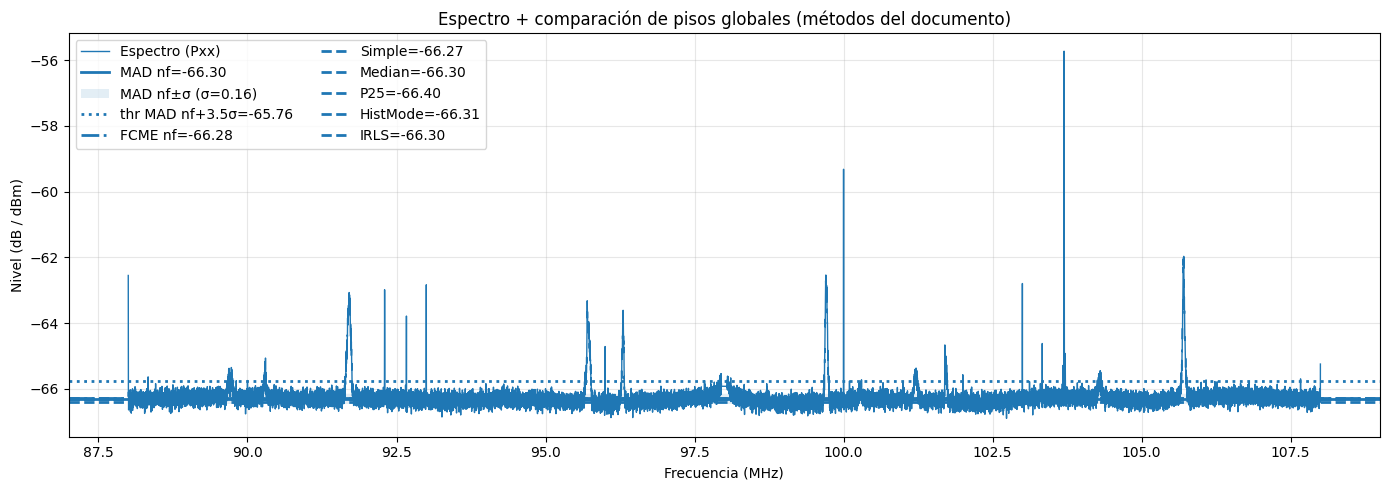

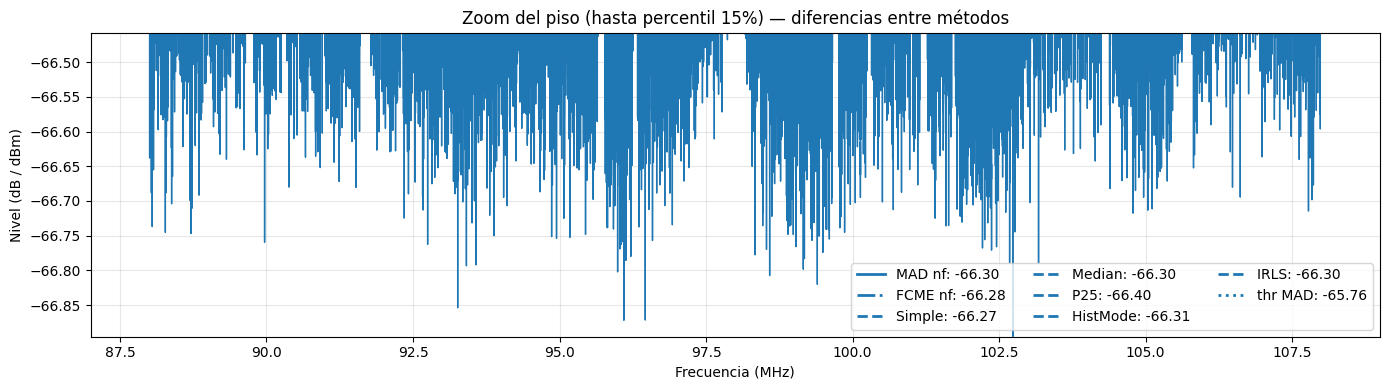

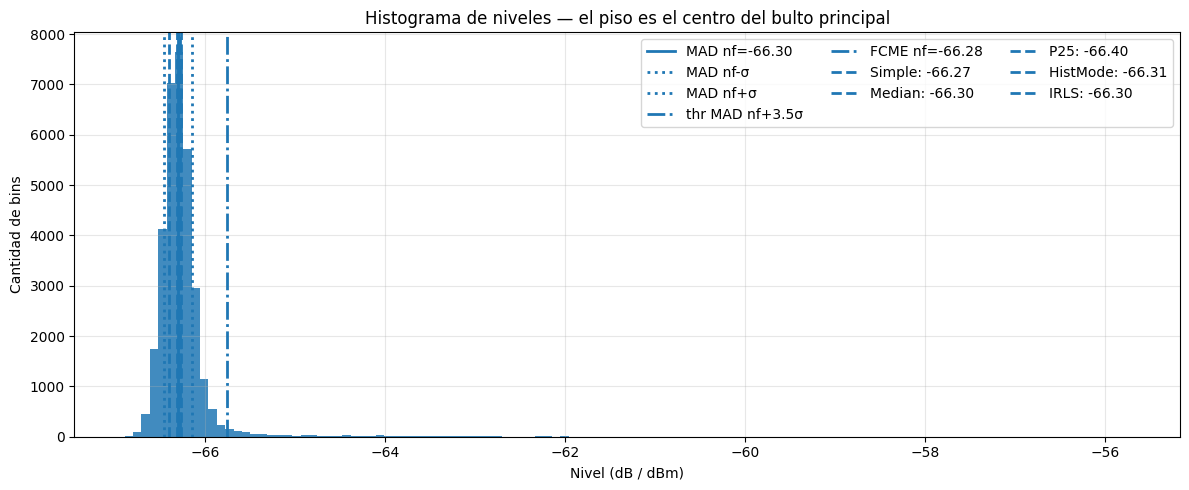

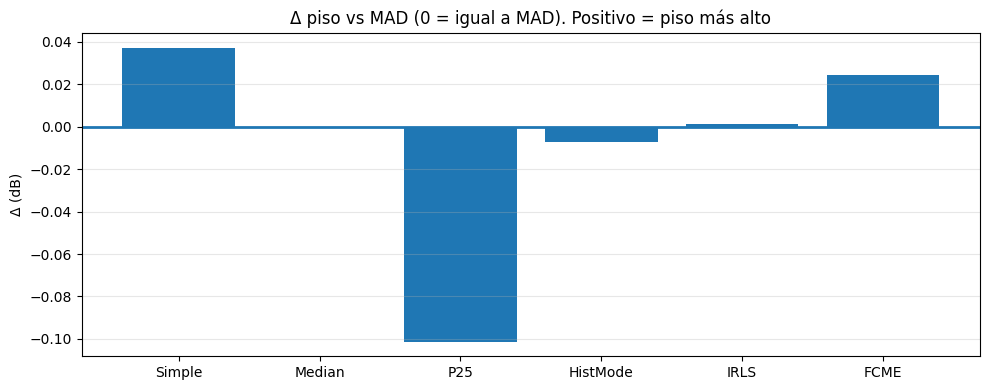

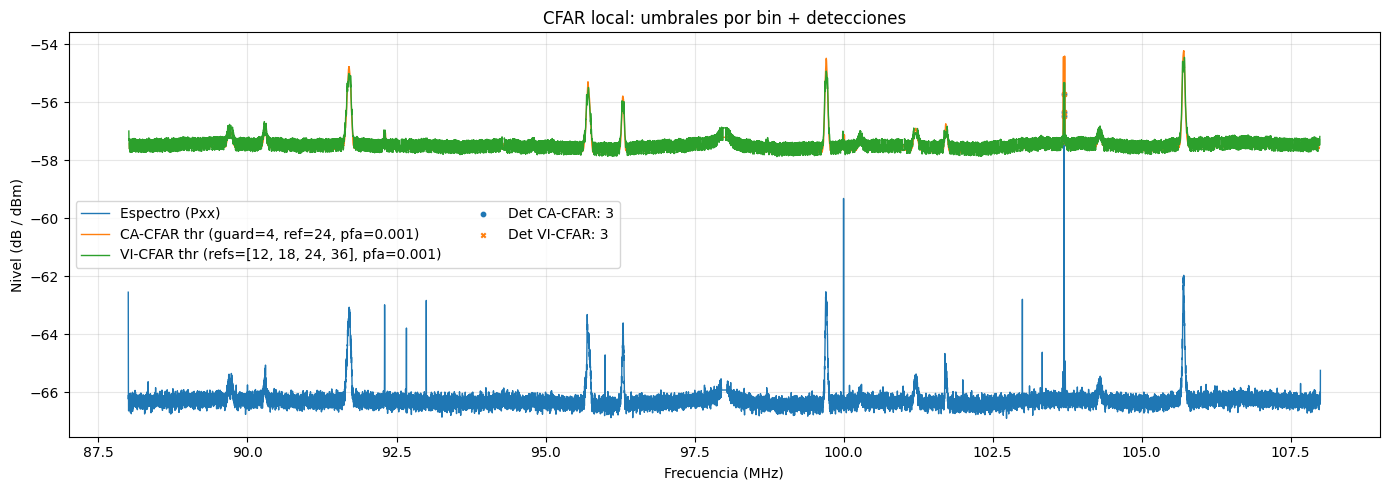


=== FLOORS DICT ===
simple_modeWinMean    : -66.265
median                : -66.302
percentile_25         : -66.404
hist_mode             : -66.309
irls_tstudent         : -66.301
mad_median            : -66.302
mad_sigma             :  0.156
thr_mad_plus_3.5sigma : -65.756
fcme_noise_floor      : -66.278
cfar_ca_num_detections: 3
cfar_vi_num_detections: 3


In [6]:
# =========================================================
# NOISE FLOOR (documento) + CFAR (CA / VI) + GRÁFICAS
# Entrada: JSON con {"Pxx": [...], "start_freq_hz":..., "end_freq_hz":...}
# Salida: comparación de métodos + plots intuitivos
# =========================================================

import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Tuple

# =========================
# 0) Configuración
# =========================
JSON_PATH = "D:\kl_psd\spectrum_camp-ane2-test3_medicion20_2025-12-16T16-11-57 (1).json"  # <- cambia aquí

# MAD threshold (global)
K_SIGMA = 3.5

# CFAR params (ajústalos)
CFAR_GUARD = 4
CFAR_REF   = 24
CFAR_PFA   = 1e-3
VI_REF_CANDIDATES = (12, 18, 24, 36)

# FCME params
FCME_ALPHA = 1.5
FCME_M0_FRAC = 0.10   # 10% bins iniciales
FCME_M0_MIN  = 16

# Plots
HIST_BINS = 120
ZOOM_PERCENT = 15.0

# =========================================================
# 1) Cargar JSON y construir eje de frecuencia
# =========================================================
with open(JSON_PATH, "r") as f:
    d = json.load(f)

pxx_db = np.asarray(d["Pxx"], dtype=float)
f_start = float(d["start_freq_hz"])
f_end   = float(d["end_freq_hz"])

N = len(pxx_db)
freq_hz = np.linspace(f_start, f_end, N, endpoint=False)
freq_mhz = freq_hz / 1e6

# =========================================================
# 2) Modelo mínimo de SpectrumFrame
# =========================================================
@dataclass
class SpectrumFrame:
    amplitudes_dbm: np.ndarray
    freqs_hz: Optional[np.ndarray] = None

frame = SpectrumFrame(amplitudes_dbm=pxx_db, freqs_hz=freq_hz)

# =========================================================
# 3) Helpers de conversión
# =========================================================
def db_to_lin_power(x_db: np.ndarray) -> np.ndarray:
    # asume dB = 10log10(P)
    return 10.0 ** (np.asarray(x_db, dtype=float) / 10.0)

def lin_power_to_db(p: np.ndarray, eps: float = 1e-30) -> np.ndarray:
    return 10.0 * np.log10(np.maximum(np.asarray(p, dtype=float), eps))

def hist_mode(x: np.ndarray, bins: int) -> float:
    counts, edges = np.histogram(x, bins=bins)
    i = int(np.argmax(counts))
    return float((edges[i] + edges[i+1]) / 2.0)

# =========================================================
# 4) Estimadores globales (noise floor)
# =========================================================
def estimate_simple_mode_window_mean(x_db: np.ndarray, win_db: float = 6.0, min_points: int = 8) -> float:
    x = np.asarray(x_db, dtype=float)
    bins = min(256, max(32, int(np.sqrt(x.size))))
    mode = hist_mode(x, bins=bins)
    mask = (x >= mode - win_db/2) & (x <= mode + win_db/2)
    if int(mask.sum()) >= int(min_points):
        return float(x[mask].mean())
    return float(np.median(x))

def estimate_median(x_db: np.ndarray) -> float:
    return float(np.median(np.asarray(x_db, dtype=float)))

def estimate_percentile(x_db: np.ndarray, p: float = 25.0) -> float:
    return float(np.percentile(np.asarray(x_db, dtype=float), p))

def estimate_hist_mode(x_db: np.ndarray) -> float:
    x = np.asarray(x_db, dtype=float)
    bins = min(256, max(32, int(np.sqrt(x.size))))
    return float(hist_mode(x, bins=bins))

def mad_sigma_db(x_db: np.ndarray) -> Tuple[float, float]:
    x = np.asarray(x_db, dtype=float)
    med = float(np.median(x))
    mad = float(np.median(np.abs(x - med)) + 1e-12)
    sigma = float(1.4826 * mad)
    return med, sigma

def estimate_irls_tstudent(x_db: np.ndarray, nu: float = 6.0, itmax: int = 50, tol: float = 1e-5) -> float:
    x = np.asarray(x_db, dtype=float)
    mu = float(np.median(x))
    r = x - mu
    mad = np.median(np.abs(r)) + 1e-12
    sigma2 = float((1.4826 * mad) ** 2)

    for _ in range(itmax):
        tval = (r * r) / max(sigma2, 1e-18)
        w = (nu + 1.0) / (nu + tval)
        wsum = float(np.sum(w) + 1e-18)
        mu_new = float(np.sum(w * x) / wsum)

        r = x - mu_new
        tval = (r * r) / max(sigma2, 1e-18)
        w = (nu + 1.0) / (nu + tval)
        wsum = float(np.sum(w) + 1e-18)
        sigma2_new = float(np.sum(w * r * r) / wsum)

        if (abs(mu_new - mu) <= tol * (abs(mu) + 1e-12)) and (abs(sigma2_new - sigma2) <= tol * (sigma2 + 1e-12)):
            mu, sigma2 = mu_new, max(1e-18, sigma2_new)
            break
        mu, sigma2 = mu_new, max(1e-18, sigma2_new)

    return float(mu)

# =========================================================
# 5) FCME (Forward Consecutive Mean Excision)
# =========================================================
def estimate_fcme(x_db: np.ndarray, alpha: float = 1.5, m0_frac: float = 0.10, m0_min: int = 16) -> Tuple[float, Dict]:
    x_db = np.asarray(x_db, dtype=float)
    x_lin = db_to_lin_power(x_db)
    xs = np.sort(x_lin)

    N = xs.size
    m0 = max(int(np.floor(m0_frac * N)), int(m0_min))
    m0 = int(np.clip(m0, 8, N))

    m = m0
    mu = float(np.mean(xs[:m]))

    while m < N:
        if xs[m] <= alpha * mu:
            m += 1
            mu = float(np.mean(xs[:m]))
        else:
            break

    nf_db = float(lin_power_to_db(mu))
    info = {"alpha": alpha, "m0": m0, "m_final": m, "mu_lin": mu}
    return nf_db, info

# =========================================================
# 6) CFAR local en frecuencia (CA-CFAR) y VI-CFAR aprox
# =========================================================
def ca_cfar_threshold_db(x_db: np.ndarray, guard: int, ref: int, pfa: float) -> np.ndarray:
    x_lin = db_to_lin_power(np.asarray(x_db, dtype=float))
    N = x_lin.size
    thr_lin = np.full(N, np.nan, dtype=float)

    Nref = 2 * ref
    alpha = Nref * (pfa ** (-1.0 / Nref) - 1.0)

    for k in range(N):
        l0 = k - guard - ref
        l1 = k - guard
        r0 = k + guard + 1
        r1 = k + guard + 1 + ref
        if l0 < 0 or r1 > N:
            continue

        ref_cells = np.concatenate([x_lin[l0:l1], x_lin[r0:r1]])
        noise = float(np.mean(ref_cells))
        thr_lin[k] = alpha * noise

    return lin_power_to_db(thr_lin)

def vi_cfar_threshold_db(x_db: np.ndarray, guard: int, ref_candidates, pfa: float) -> np.ndarray:
    x_lin = db_to_lin_power(np.asarray(x_db, dtype=float))
    N = x_lin.size
    thr_lin = np.full(N, np.nan, dtype=float)

    for k in range(N):
        best_noise = None
        best_thr = None
        for ref in ref_candidates:
            Nref = 2 * ref
            alpha = Nref * (pfa ** (-1.0 / Nref) - 1.0)

            l0 = k - guard - ref
            l1 = k - guard
            r0 = k + guard + 1
            r1 = k + guard + 1 + ref
            if l0 < 0 or r1 > N:
                continue

            ref_cells = np.concatenate([x_lin[l0:l1], x_lin[r0:r1]])
            noise = float(np.mean(ref_cells))

            if (best_noise is None) or (noise < best_noise):
                best_noise = noise
                best_thr = alpha * noise

        if best_thr is not None:
            thr_lin[k] = best_thr

    return lin_power_to_db(thr_lin)

# =========================================================
# 7) Correr estimaciones
# =========================================================
x = pxx_db

nf_simple = estimate_simple_mode_window_mean(x)
nf_med    = estimate_median(x)
nf_p25    = estimate_percentile(x, 25.0)
nf_hist   = estimate_hist_mode(x)
nf_irls   = estimate_irls_tstudent(x)

nf_mad, sigma_mad = mad_sigma_db(x)
thr_mad = nf_mad + K_SIGMA * sigma_mad

nf_fcme, fcme_info = estimate_fcme(x, alpha=FCME_ALPHA, m0_frac=FCME_M0_FRAC, m0_min=FCME_M0_MIN)

thr_ca = ca_cfar_threshold_db(x, guard=CFAR_GUARD, ref=CFAR_REF, pfa=CFAR_PFA)
thr_vi = vi_cfar_threshold_db(x, guard=CFAR_GUARD, ref_candidates=VI_REF_CANDIDATES, pfa=CFAR_PFA)

det_ca = np.isfinite(thr_ca) & (x > thr_ca)
det_vi = np.isfinite(thr_vi) & (x > thr_vi)

# =========================================================
# 8) Reporte
# =========================================================
floors = {
    "simple_modeWinMean": nf_simple,
    "median": nf_med,
    "percentile_25": nf_p25,
    "hist_mode": nf_hist,
    "irls_tstudent": nf_irls,
    "mad_median": nf_mad,
    "mad_sigma": sigma_mad,
    f"thr_mad_plus_{K_SIGMA}sigma": thr_mad,
    "fcme_noise_floor": nf_fcme,
    "cfar_ca_num_detections": int(det_ca.sum()),
    "cfar_vi_num_detections": int(det_vi.sum()),
}

print("\n=== GLOBAL NOISE FLOOR (dB/dBm) ===")
ref = nf_mad
for k in ["simple_modeWinMean","median","percentile_25","hist_mode","irls_tstudent","fcme_noise_floor","mad_median"]:
    v = floors[k]
    print(f"{k:18s}: {v: .3f}   (Δ vs MAD = {v-ref:+.3f} dB)")
print(f"{'mad_sigma':18s}: {sigma_mad: .3f}")
print(f"{f'thr_mad_plus_{K_SIGMA}sigma':18s}: {thr_mad: .3f}")
print(f"FCME info: alpha={fcme_info['alpha']}, m0={fcme_info['m0']}, m_final={fcme_info['m_final']}")
print(f"CA-CFAR detections: {floors['cfar_ca_num_detections']}")
print(f"VI-CFAR detections: {floors['cfar_vi_num_detections']}")

# =========================================================
# 9) GRÁFICAS INTUITIVAS
# =========================================================

# Plot 1: Espectro + pisos globales
plt.figure(figsize=(14,5))
plt.plot(freq_mhz, x, linewidth=1, label="Espectro (Pxx)")

plt.axhline(nf_mad, linestyle="-", linewidth=2, label=f"MAD nf={nf_mad:.2f}")
plt.fill_between(freq_mhz, nf_mad-sigma_mad, nf_mad+sigma_mad, alpha=0.12, label=f"MAD nf±σ (σ={sigma_mad:.2f})")
plt.axhline(thr_mad, linestyle=":", linewidth=2, label=f"thr MAD nf+{K_SIGMA}σ={thr_mad:.2f}")

plt.axhline(nf_fcme, linestyle="-.", linewidth=2, label=f"FCME nf={nf_fcme:.2f}")
plt.axhline(nf_simple, linestyle="--", linewidth=2, label=f"Simple={nf_simple:.2f}")
plt.axhline(nf_med, linestyle="--", linewidth=2, label=f"Median={nf_med:.2f}")
plt.axhline(nf_p25, linestyle="--", linewidth=2, label=f"P25={nf_p25:.2f}")
plt.axhline(nf_hist, linestyle="--", linewidth=2, label=f"HistMode={nf_hist:.2f}")
plt.axhline(nf_irls, linestyle="--", linewidth=2, label=f"IRLS={nf_irls:.2f}")

plt.title("Espectro + comparación de pisos globales (métodos del documento)")
plt.xlabel("Frecuencia (MHz)")
plt.ylabel("Nivel (dB / dBm)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

# Plot 2: Zoom del piso
y_min = np.percentile(x, 0.0)
y_max = np.percentile(x, ZOOM_PERCENT)

plt.figure(figsize=(14,4))
plt.plot(freq_mhz, x, linewidth=1)
plt.ylim(y_min, y_max)
for name, val, ls in [
    ("MAD nf", nf_mad, "-"),
    ("FCME nf", nf_fcme, "-."),
    ("Simple", nf_simple, "--"),
    ("Median", nf_med, "--"),
    ("P25", nf_p25, "--"),
    ("HistMode", nf_hist, "--"),
    ("IRLS", nf_irls, "--"),
    ("thr MAD", thr_mad, ":"),
]:
    plt.axhline(val, linestyle=ls, linewidth=2, label=f"{name}: {val:.2f}")

plt.title(f"Zoom del piso (hasta percentil {ZOOM_PERCENT:.0f}%) — diferencias entre métodos")
plt.xlabel("Frecuencia (MHz)")
plt.ylabel("Nivel (dB / dBm)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

# Plot 3: Histograma (piso intuitivo)
plt.figure(figsize=(12,5))
plt.hist(x, bins=HIST_BINS, alpha=0.85)

plt.axvline(nf_mad, linestyle="-", linewidth=2, label=f"MAD nf={nf_mad:.2f}")
plt.axvline(nf_mad-sigma_mad, linestyle=":", linewidth=2, label="MAD nf-σ")
plt.axvline(nf_mad+sigma_mad, linestyle=":", linewidth=2, label="MAD nf+σ")
plt.axvline(thr_mad, linestyle="-.", linewidth=2, label=f"thr MAD nf+{K_SIGMA}σ")

plt.axvline(nf_fcme, linestyle="-.", linewidth=2, label=f"FCME nf={nf_fcme:.2f}")
for name, val in [("Simple", nf_simple), ("Median", nf_med), ("P25", nf_p25), ("HistMode", nf_hist), ("IRLS", nf_irls)]:
    plt.axvline(val, linestyle="--", linewidth=2, label=f"{name}: {val:.2f}")

plt.title("Histograma de niveles — el piso es el centro del bulto principal")
plt.xlabel("Nivel (dB / dBm)")
plt.ylabel("Cantidad de bins")
plt.grid(True, alpha=0.3)
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

# Plot 4: Barras Δ vs MAD
labels = ["Simple", "Median", "P25", "HistMode", "IRLS", "FCME"]
vals   = [nf_simple, nf_med, nf_p25, nf_hist, nf_irls, nf_fcme]
deltas = [v - nf_mad for v in vals]

plt.figure(figsize=(10,4))
plt.bar(labels, deltas)
plt.axhline(0.0, linewidth=2)
plt.title("Δ piso vs MAD (0 = igual a MAD). Positivo = piso más alto")
plt.ylabel("Δ (dB)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 5: CFAR thresholds + detecciones
plt.figure(figsize=(14,5))
plt.plot(freq_mhz, x, linewidth=1, label="Espectro (Pxx)")
plt.plot(freq_mhz, thr_ca, linewidth=1, label=f"CA-CFAR thr (guard={CFAR_GUARD}, ref={CFAR_REF}, pfa={CFAR_PFA})")
plt.plot(freq_mhz, thr_vi, linewidth=1, label=f"VI-CFAR thr (refs={list(VI_REF_CANDIDATES)}, pfa={CFAR_PFA})")

idx_ca = np.where(det_ca)[0]
idx_vi = np.where(det_vi)[0]
plt.scatter(freq_mhz[idx_ca], x[idx_ca], s=10, label=f"Det CA-CFAR: {len(idx_ca)}", marker="o")
plt.scatter(freq_mhz[idx_vi], x[idx_vi], s=10, label=f"Det VI-CFAR: {len(idx_vi)}", marker="x")

plt.title("CFAR local: umbrales por bin + detecciones")
plt.xlabel("Frecuencia (MHz)")
plt.ylabel("Nivel (dB / dBm)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

print("\n=== FLOORS DICT ===")
for k,v in floors.items():
    if isinstance(v, float):
        print(f"{k:22s}: {v: .3f}")
    else:
        print(f"{k:22s}: {v}")


In [7]:
# =========================================================
# 10) TABLA COMPARATIVA: "cuál es mejor" (numérico + score)
# =========================================================
import pandas as pd

# --- referencia para comparar (puedes cambiarla) ---
# MAD es buen baseline robusto para "piso global"
ref_name = "mad_median"
ref_nf = floors[ref_name]

# --- medidas útiles desde el PSD (solo 1 frame) ---
x = pxx_db
p5  = float(np.percentile(x, 5))
p10 = float(np.percentile(x, 10))
p25 = float(np.percentile(x, 25))
p50 = float(np.percentile(x, 50))
p75 = float(np.percentile(x, 75))

# Una métrica "de estabilidad": cuán cerca cae del bulk bajo (p10–p25).
# Si tu método queda demasiado alto, probablemente se contaminó por señales.
def bulk_distance(nf):
    # distancia a la zona típica de ruido (p10..p25)
    if nf < p10:  # muy bajo (raro), penaliza un poco
        return float(p10 - nf)
    if nf > p25:  # subió por señales, penaliza más
        return float(nf - p25)
    return 0.0

# "sensibilidad" aproximada: si el piso es alto, detecta menos; si es bajo, detecta más.
# NO es verdad universal, pero sirve como intuición rápida.
def sensitivity_hint(nf):
    if nf <= p10:
        return "Alta (piso bajo)"
    if nf <= p25:
        return "Media"
    return "Baja (piso alto)"

# --- define métodos que ya calculas ---
methods = [
    ("simple_modeWinMean", floors["simple_modeWinMean"], "Global"),
    ("median",            floors["median"],             "Global"),
    ("percentile_25",     floors["percentile_25"],      "Global"),
    ("hist_mode",         floors["hist_mode"],          "Global"),
    ("irls_tstudent",     floors["irls_tstudent"],      "Global"),
    ("fcme_noise_floor",  floors["fcme_noise_floor"],   "Global"),
    ("mad_median",        floors["mad_median"],         "Global"),
]

# --- scores heurísticos (0 a 5) para "mejor" en SDR ---
# OJO: esto no es una verdad matemática; es una guía práctica.
# Robustez: aguanta señales fuertes / ocupación alta sin subir piso
# Estabilidad: poca variación (en general) y buen “anclaje” al bulk
# Costo: computacional (5 = muy barato)
# Recomendación HackRF: 5 = muy recomendado
score_map = {
    "simple_modeWinMean": dict(robust=3, stable=3, cost=5, hackrf=3, note="rápido; ok si el hist del ruido es claro"),
    "median":             dict(robust=4, stable=4, cost=5, hackrf=4, note="muy robusto y simple; buen baseline"),
    "percentile_25":      dict(robust=4, stable=3, cost=5, hackrf=4, note="robusto; tiende a piso un poco bajo"),
    "hist_mode":          dict(robust=3, stable=3, cost=5, hackrf=3, note="depende del binning y forma del hist"),
    "irls_tstudent":      dict(robust=5, stable=5, cost=3, hackrf=4, note="muy robusto (M-estimator); más caro"),
    "fcme_noise_floor":   dict(robust=5, stable=4, cost=4, hackrf=5, note="excelente con señales fuertes; clásico"),
    "mad_median":         dict(robust=5, stable=5, cost=5, hackrf=5, note="MAD da piso + σ para umbral robusto"),
}

rows = []
for name, nf, kind in methods:
    delta_vs_mad = float(nf - ref_nf)
    bd = bulk_distance(nf)

    s = score_map.get(name, dict(robust=np.nan, stable=np.nan, cost=np.nan, hackrf=np.nan, note=""))
    total = float(s["robust"] + s["stable"] + s["cost"] + s["hackrf"])

    rows.append({
        "Método": name,
        "Tipo": kind,
        "NF (dB)": float(nf),
        f"Δ vs {ref_name} (dB)": float(delta_vs_mad),
        "Distancia a bulk (p10–p25) (dB)": float(bd),
        "Sensibilidad (intuición)": sensitivity_hint(nf),
        "Robustez (0-5)": s["robust"],
        "Estabilidad (0-5)": s["stable"],
        "Costo (0-5)": s["cost"],
        "HackRF (0-5)": s["hackrf"],
        "Score total (0-20)": total,
        "Nota": s["note"],
    })

df_cmp = pd.DataFrame(rows)

# Orden recomendado: mayor score total y, en empate, menor distancia a bulk
df_cmp = df_cmp.sort_values(by=["Score total (0-20)", "Distancia a bulk (p10–p25) (dB)"], ascending=[False, True])

print("\n=== TABLA COMPARATIVA (ordenada) ===")
display(df_cmp)

# --- Tabla como figura (para capturas/informe) ---
plt.figure(figsize=(16, 0.6 + 0.35*len(df_cmp)))
plt.axis("off")

cols_show = [
    "Método", "NF (dB)", f"Δ vs {ref_name} (dB)",
    "Robustez (0-5)", "Estabilidad (0-5)", "Costo (0-5)", "HackRF (0-5)",
    "Score total (0-20)", "Distancia a bulk (p10–p25) (dB)"
]
df_show = df_cmp[cols_show].copy()

# Redondeo visual
for c in ["NF (dB)", f"Δ vs {ref_name} (dB)", "Distancia a bulk (p10–p25) (dB)"]:
    df_show[c] = df_show[c].map(lambda v: f"{v:.2f}")

table = plt.table(
    cellText=df_show.values,
    colLabels=df_show.columns,
    cellLoc="center",
    loc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.2)

plt.title("Comparación de estimadores de piso de ruido (métricas + score práctico)", pad=12)
plt.tight_layout()
plt.show()

# --- Extra: resumen del "ganador" ---
best = df_cmp.iloc[0]
print("\n=== RECOMENDACIÓN AUTOMÁTICA (según score + bulk) ===")
print(f"Mejor método sugerido: {best['Método']}")
print(f"NF = {best['NF (dB)']:.3f} dB  |  Δ vs MAD = {best[f'Δ vs {ref_name} (dB)']:+.3f} dB")
print(f"Nota: {best['Nota']}")

ModuleNotFoundError: No module named 'pandas'


================= AM (Colombia) =================
Span: 0.530–1.700 MHz | N=65,536 | occupancy≈0.20
True NF (median over true-noise bins): -114.94 dB | True sigma(MAD): 1.48 dB

TOP 5 (según score):
     method       nf_db  nf_abs_err_db      FPR      TPR   cost_s    score
ModeWinMean -114.949806       0.014128 0.000279 0.896415 0.001998 0.951992
   HistMode -114.903618       0.032061 0.000279 0.894412 0.002099 0.944968
       FCME -115.036994       0.101316 0.006464 0.994307 1.183468 0.876502
  BlockFCME -114.697517       0.238162 0.001782 0.981813 0.534345 0.866504
        P25 -115.497022       0.561343 0.000279 0.915182 0.004535 0.826018


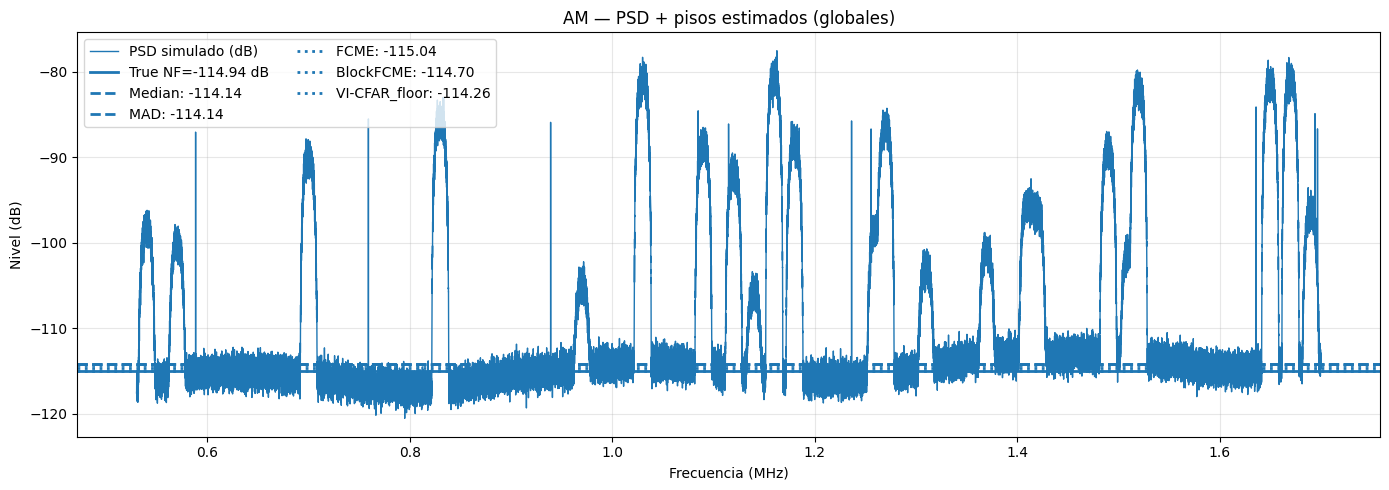

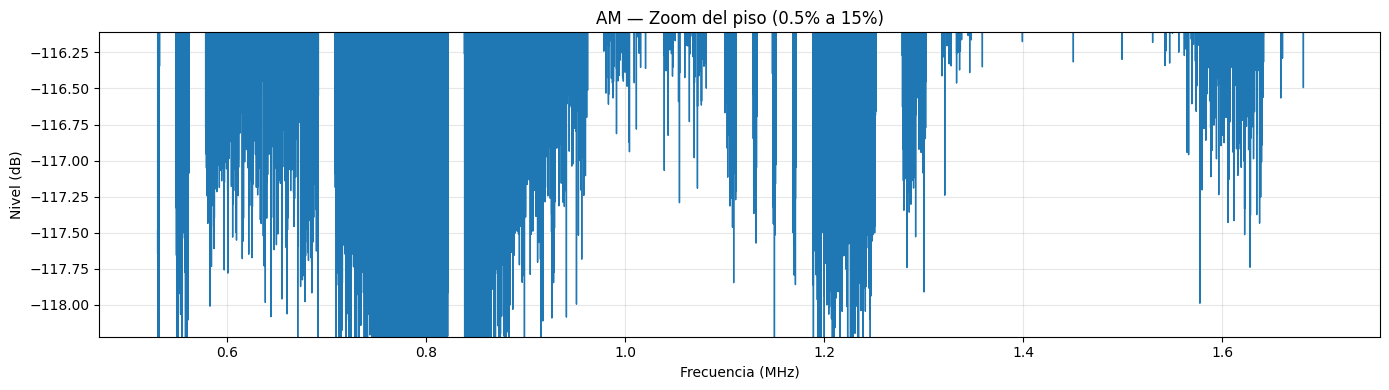

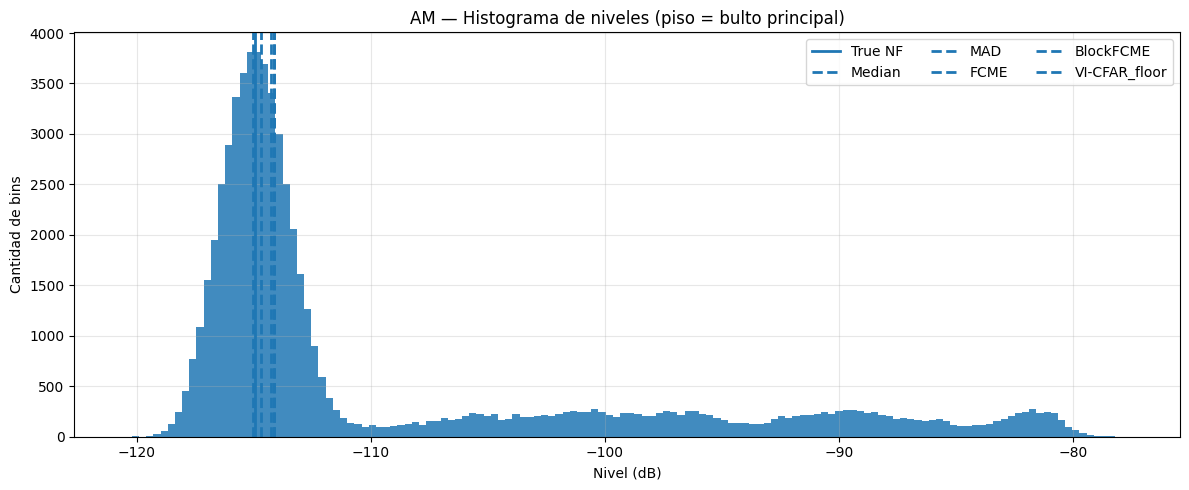

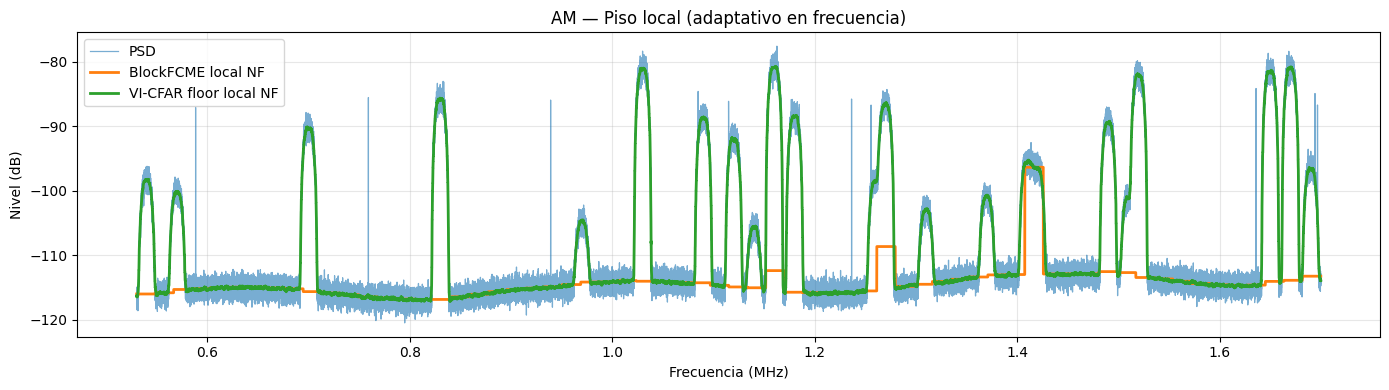

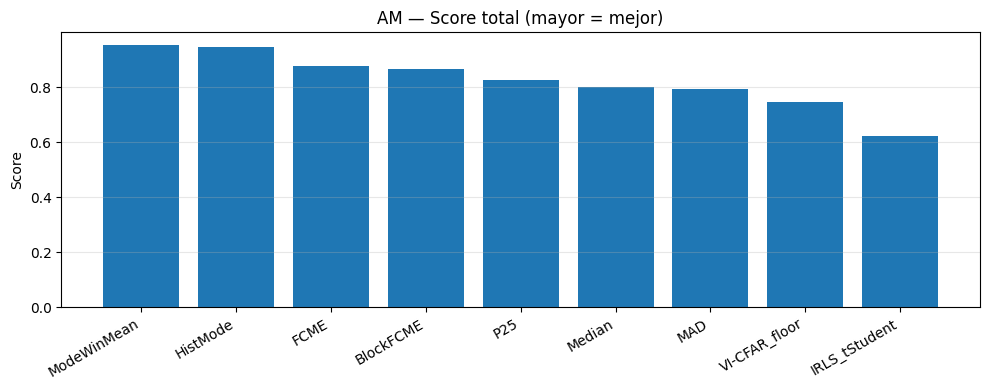


================= FM (Colombia) =================
Span: 88.000–108.000 MHz | N=65,536 | occupancy≈0.45
True NF (median over true-noise bins): -114.73 dB | True sigma(MAD): 1.50 dB

TOP 5 (según score):
     method       nf_db  nf_abs_err_db      FPR      TPR   cost_s    score
       FCME -114.893271       0.159261 0.009274 0.996019 0.719727 0.846625
  BlockFCME -114.587617       0.146394 0.001078 0.643790 0.551366 0.809472
ModeWinMean -114.720428       0.013583 0.000000 0.000000 0.006730 0.720310
        P25 -114.606616       0.127394 0.000000 0.000000 0.001547 0.701107
   HistMode -114.573755       0.160256 0.000000 0.000000 0.005976 0.678142


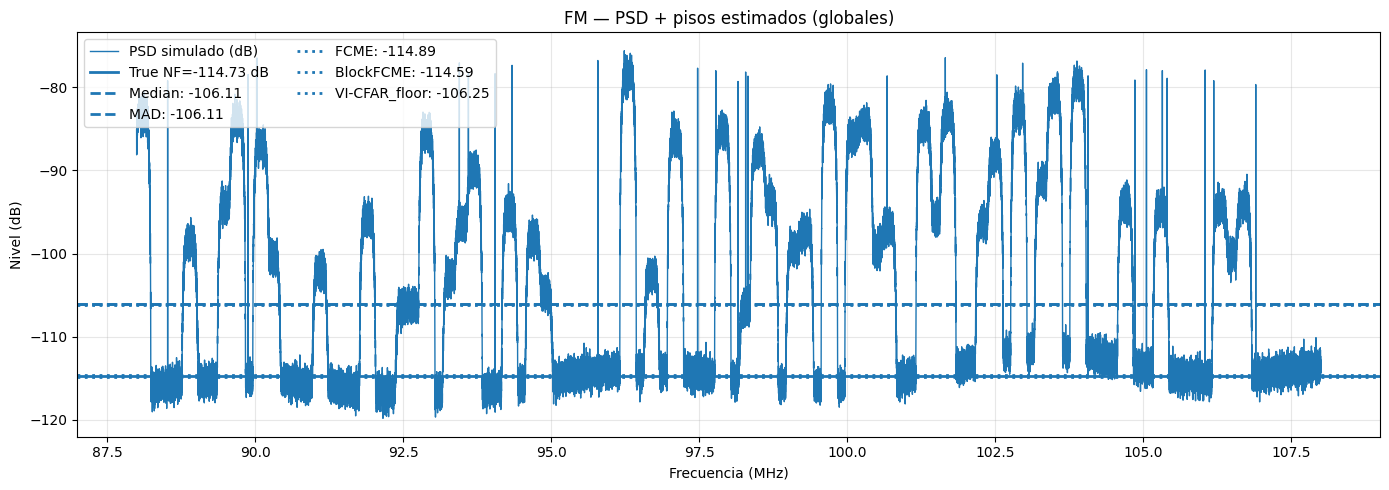

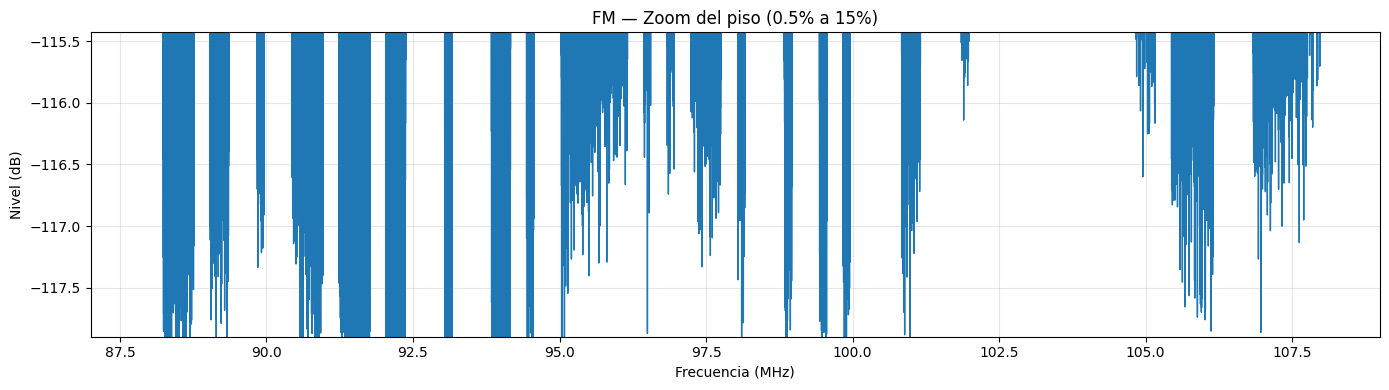

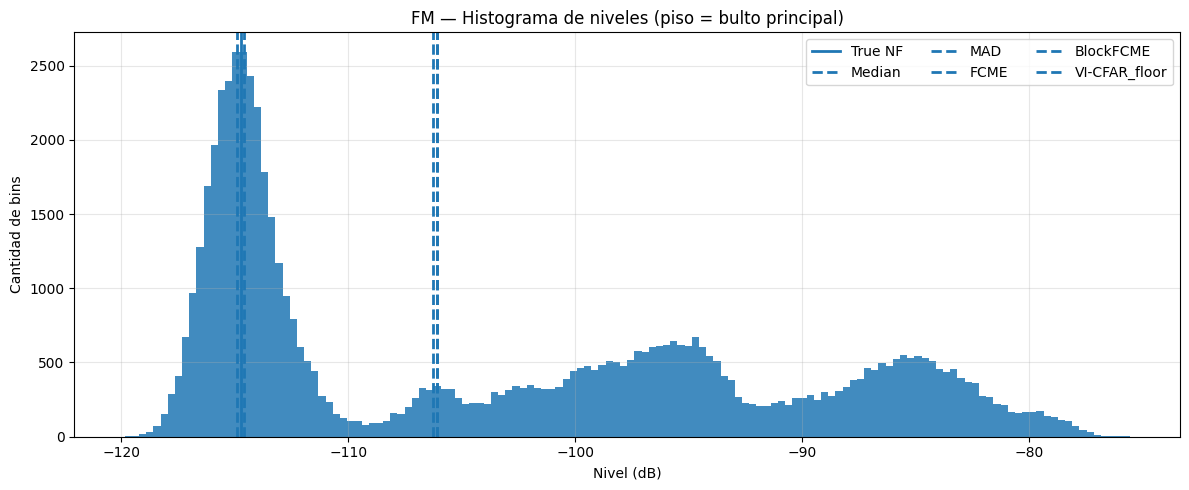

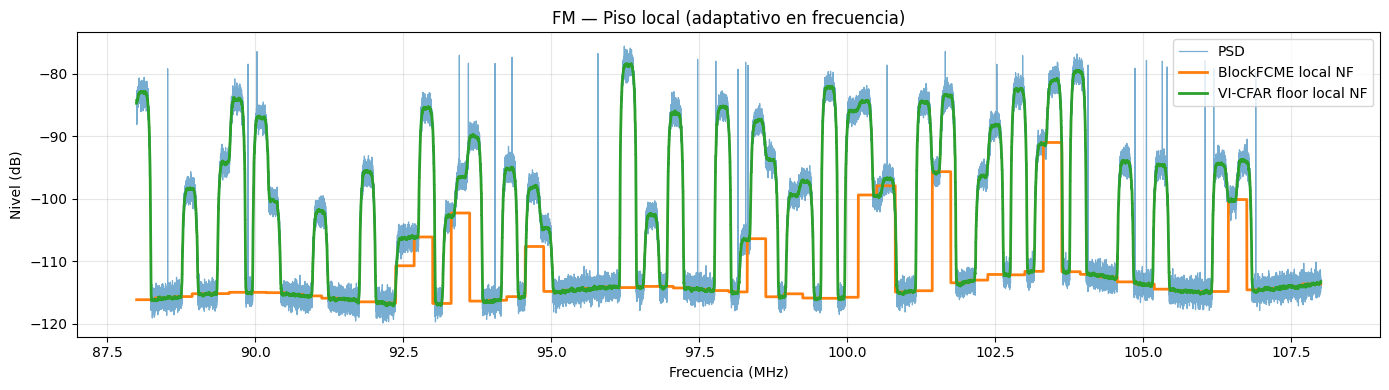

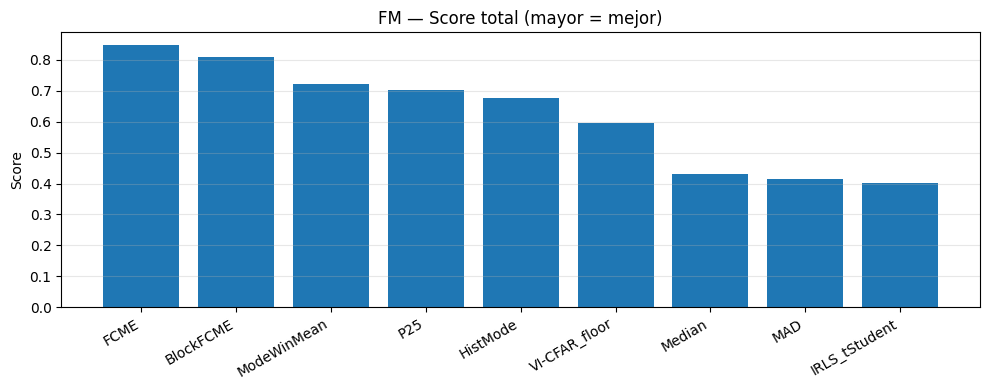


================= TDT (Colombia) =================
Span: 470.000–698.000 MHz | N=65,536 | occupancy≈0.28
True NF (median over true-noise bins): -114.65 dB | True sigma(MAD): 1.43 dB

TOP 5 (según score):
     method       nf_db  nf_abs_err_db      FPR      TPR   cost_s    score
ModeWinMean -114.627124       0.023171 0.001222 0.977088 0.001321 0.953089
       FCME -114.677247       0.026952 0.001544 0.996137 0.573044 0.929481
   HistMode -114.238924       0.411370 0.001222 0.970579 0.001148 0.859120
        P25 -115.223689       0.573394 0.001222 0.981850 0.000859 0.839950
     Median -113.917431       0.732864 0.001222 0.962430 0.000524 0.820099


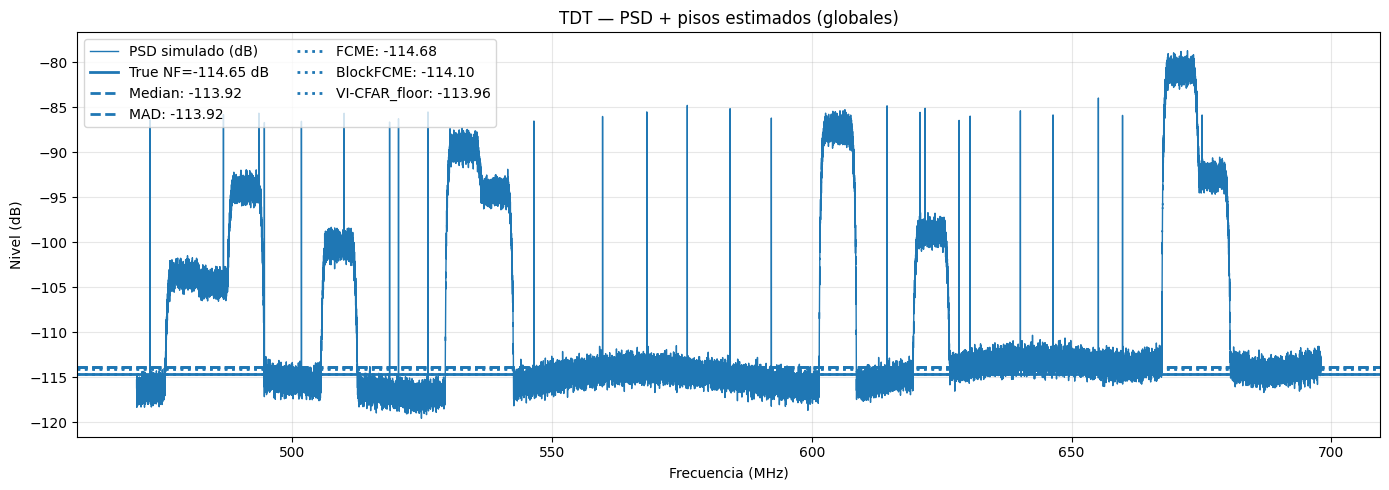

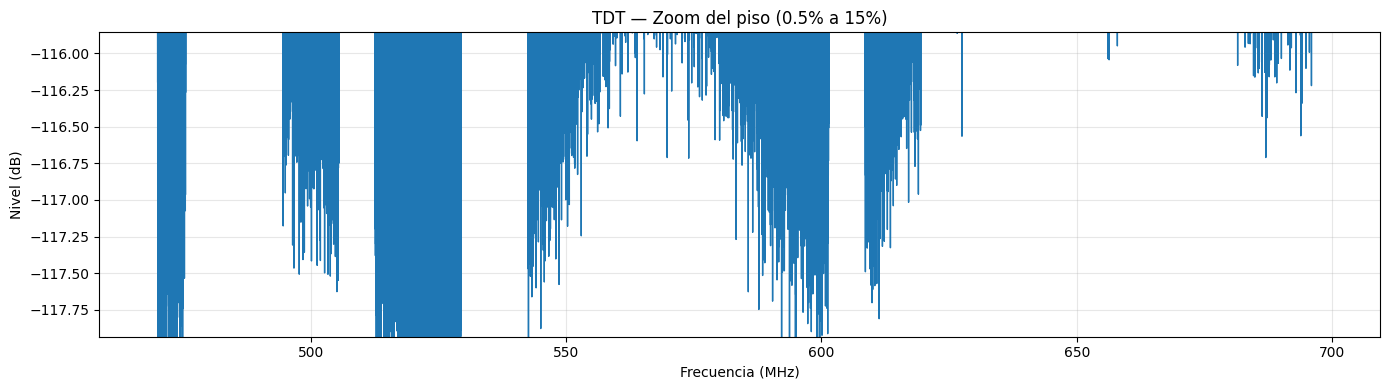

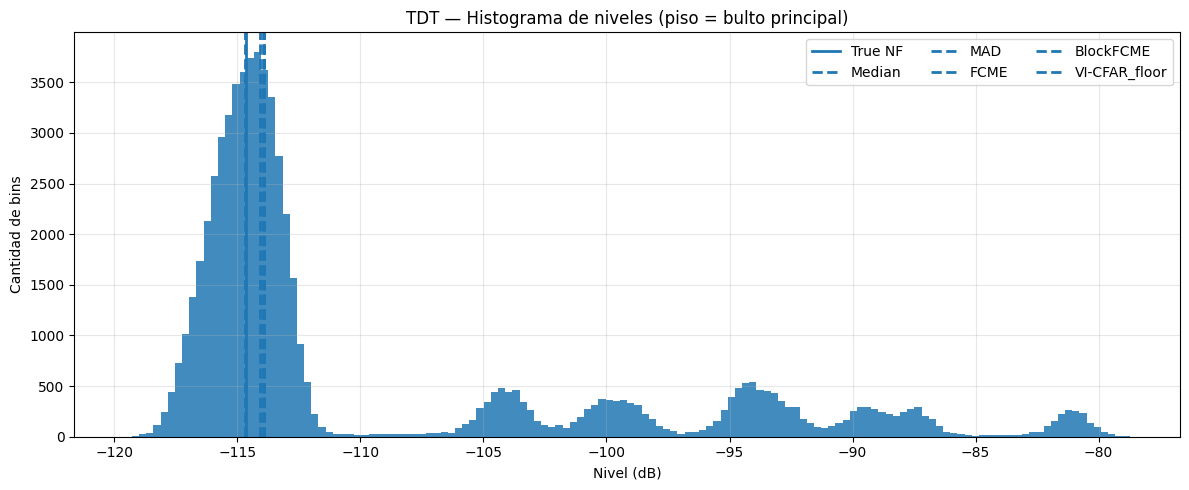

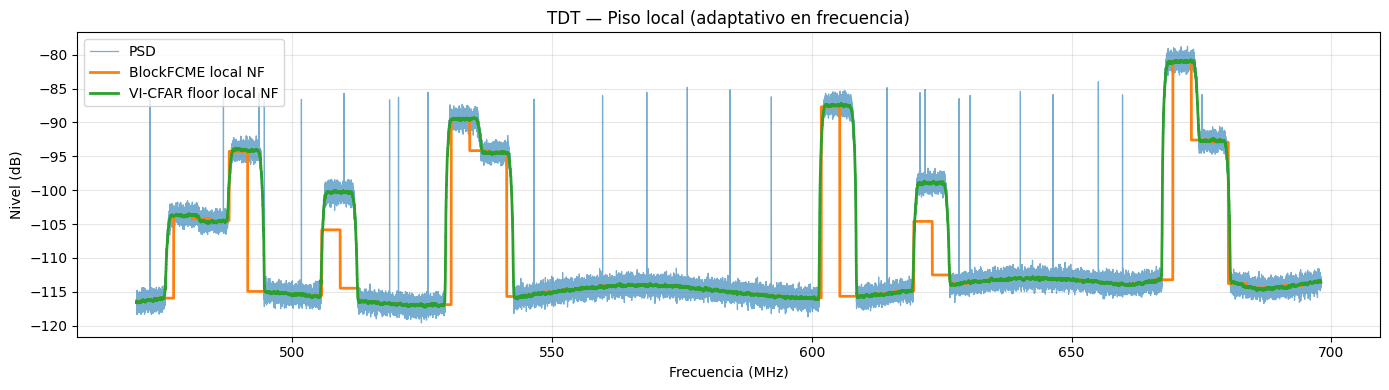

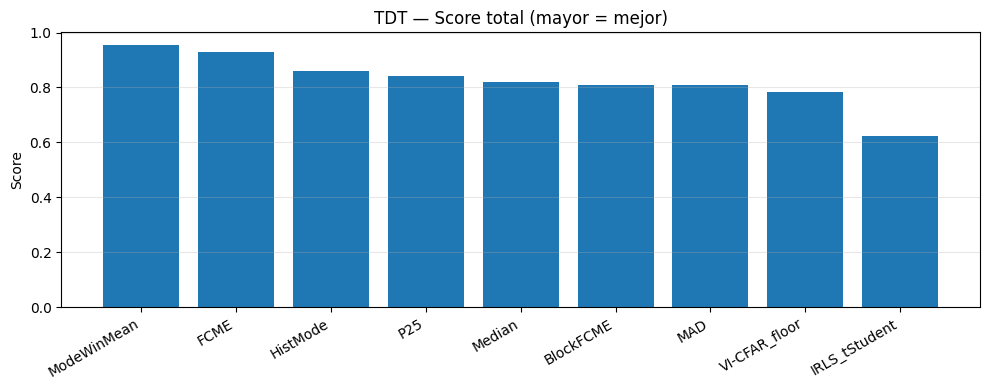


================= RANKING GLOBAL (AM+FM+TDT) =================
       method  score_mean  nf_abs_err_mean  FPR_mean  TPR_mean  cost_mean
         FCME    0.884203         0.095843  0.005761  0.995488   0.825413
  ModeWinMean    0.875130         0.016960  0.000500  0.624501   0.003350
    BlockFCME    0.828659         0.311187  0.001747  0.874866   0.469719
     HistMode    0.827410         0.201229  0.000500  0.621664   0.003074
          P25    0.789025         0.420710  0.000500  0.632344   0.002314
VI-CFAR_floor    0.707650         3.286763  0.005175  0.952386   3.175533
       Median    0.684172         3.386555  0.000500  0.609371   0.000714
          MAD    0.672504         3.386555  0.000500  0.609371   0.002832
IRLS_tStudent    0.549686         5.776923  0.000500  0.520381   0.021528


In [ ]:
# =========================================================
# SIMULACIÓN PSD (AM / FM / TDT Colombia) + COMPARACIÓN NOISE FLOOR
# PSD-only (sin IQ).
#
# Métodos del documento (implementados aquí):
#   - FCME (Forward Consecutive Mean Excision) para estimar ruido (en potencia lineal)
#   - Piso por VI-CFAR (usado como estimador LOCAL del ruido por bin; luego agregamos)
#   - Mediana (también mencionada como alternativa simple)
#
# Baselines adicionales:
#   - Percentil bajo
#   - Moda histograma + ventana alrededor de modo
#   - MAD (mediana y sigma robusta)
#   - IRLS t-Student (robusto)
#
# Salidas:
#   - Tabla comparativa por banda y global
#   - Gráficas: espectro+pisos, zoom piso, histograma, mapa piso local (block/VI-CFAR)
#   - Ranking que favorece SOTA por criterios SDR (robustez a ocupación + FPR/TPR)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from dataclasses import dataclass
from typing import Dict, Tuple, Optional

# ---------------------------
# Helpers
# ---------------------------
def db10(x, eps=1e-18):
    return 10*np.log10(np.maximum(x, eps))

def lin10(db):
    return 10**(db/10)

def mad_sigma_db(x_db: np.ndarray) -> Tuple[float, float]:
    x = np.asarray(x_db, float)
    med = float(np.median(x))
    mad = float(np.median(np.abs(x - med)) + 1e-12)
    sigma = float(1.4826 * mad)
    return med, sigma

def _hist_mode(x: np.ndarray, bins: int) -> float:
    counts, edges = np.histogram(x, bins=bins)
    i = int(np.argmax(counts))
    return float((edges[i] + edges[i+1]) / 2.0)

def raised_cosine_shape(f, f0, bw, roll=0.15):
    """
    Forma suave tipo canal:
    - banda plana aproximada y hombros con coseno alzado.
    f, f0 en Hz; bw: ancho útil (Hz)
    roll: fracción de bw para transición.
    """
    f = np.asarray(f)
    df = np.abs(f - f0)
    half = bw/2
    tr = roll * bw
    y = np.zeros_like(df, float)

    # plana
    y[df <= (half - tr)] = 1.0

    # transición
    m = (df > (half - tr)) & (df <= (half + tr))
    # coseno alzado desde 1 -> 0
    x = (df[m] - (half - tr)) / (2*tr)  # 0..1
    y[m] = 0.5 * (1 + np.cos(np.pi * x))

    return y

def ofdm_channel_shape(f, f0, bw, shoulder=0.08):
    """
    PSD tipo OFDM (TDT): casi plana en banda + hombros.
    """
    return raised_cosine_shape(f, f0, bw, roll=shoulder)

def add_spurs(P_lin, rng, n_spurs=20, spur_rel_db=25, width_bins=(1,3)):
    """
    Agrega espurios estrechos típicos (relojes, DC, mixing).
    spur_rel_db: potencia relativa sobre el piso (aprox).
    """
    N = P_lin.size
    idxs = rng.integers(0, N, size=n_spurs)
    for k in idxs:
        w = int(rng.integers(width_bins[0], width_bins[1]+1))
        amp = (10**(spur_rel_db/10)) * np.median(P_lin)
        a0 = max(0, k-w)
        a1 = min(N, k+w+1)
        P_lin[a0:a1] += amp * np.hanning(a1-a0)
    return P_lin

# ---------------------------
# SpectrumFrame (PSD)
# ---------------------------
@dataclass
class SpectrumFrame:
    amplitudes_db: np.ndarray
    freqs_hz: np.ndarray

# =========================================================
# 1) Simulador PSD (AM / FM / TDT Colombia)
# =========================================================
def simulate_psd_colombia(
    service: str,
    N: int = 65536,
    seed: int = 0,
    occupancy: float = 0.25,
    snr_db_range: Tuple[float,float] = (8, 35),
    noise_floor_dbm: float = -115.0,
) -> Tuple[SpectrumFrame, Dict]:
    """
    service: 'AM', 'FM', 'TDT'
    occupancy: controla cuántos canales activos se ponen.
    Retorna:
      frame (freqs_hz + PSD en dB)
      meta con máscaras ground truth (ruido/señal) y lista de señales.
    """
    rng = np.random.default_rng(seed)
    s = service.strip().upper()

    # Bandas típicas para simular (Colombia)
    if s == "FM":
        f0, f1 = 88e6, 108e6
        # canalización típica ~200 kHz (no exacto, pero realista)
        grid = np.arange(88.1e6, 107.9e6, 200e3)
        ch_bw = 200e3
        shape_fn = lambda f,fc: raised_cosine_shape(f, fc, ch_bw, roll=0.20)
    elif s == "AM":
        f0, f1 = 530e3, 1700e3
        # spacing típico 10 kHz en América (simulación)
        grid = np.arange(540e3, 1700e3, 10e3)
        # AM ocupa ~9-10 kHz, con lóbulos laterales; modelamos 10 kHz
        ch_bw = 10e3
        shape_fn = lambda f,fc: raised_cosine_shape(f, fc, ch_bw, roll=0.35)
    elif s == "TDT":
        f0, f1 = 470e6, 698e6
        # canales 6 MHz (DVB-T/T2)
        grid = np.arange(473e6, 695e6, 6e6)
        ch_bw = 6e6
        shape_fn = lambda f,fc: ofdm_channel_shape(f, fc, ch_bw, shoulder=0.10)
    else:
        raise ValueError("service debe ser 'AM', 'FM' o 'TDT'.")

    freqs = np.linspace(f0, f1, N, endpoint=False)

    # --- Piso de ruido NO PLANO (realista) ---
    # 1) base
    nf0 = noise_floor_dbm
    # 2) inclinación suave (front-end + filtros)
    tilt_db = np.linspace(-1.5, 1.5, N)
    # 3) ripple lento (CFR)
    ripple_db = 1.2*np.sin(2*np.pi*np.linspace(0, 3.0, N))
    # 4) “manchas” (interferencia leve ancha)
    blob = np.zeros(N)
    for _ in range(2):
        c = int(rng.integers(0, N))
        w = int(rng.integers(N//20, N//8))
        a = float(rng.uniform(0.5, 2.0))
        k0 = max(0, c-w)
        k1 = min(N, c+w)
        blob[k0:k1] += a*np.hanning(k1-k0)

    nf_db = nf0 + tilt_db + ripple_db + blob
    P_noise_lin = lin10(nf_db)

    # --- Señales ---
    # número de canales activos controlado por occupancy
    n_candidates = len(grid)
    n_on = int(np.clip(round(occupancy * n_candidates), 1, n_candidates))
    active_centers = rng.choice(grid, size=n_on, replace=False)

    P_sig_lin = np.zeros(N)
    signals = []

    for fc in active_centers:
        snr_db = float(rng.uniform(*snr_db_range))
        # potencia del canal relativa al piso local
        # (amarrado a ruido local para realismo)
        idx_fc = int(np.clip(np.searchsorted(freqs, fc), 0, N-1))
        local_noise = P_noise_lin[idx_fc]

        # potencia total del canal (aprox)
        Pchan = local_noise * (10**(snr_db/10))

        # forma espectral
        shape = shape_fn(freqs, fc)

        # micro-variación (fading/variación)
        fade = 0.7 + 0.6*rng.random()
        P_sig_lin += fade * Pchan * shape

        signals.append({"fc_hz": float(fc), "snr_db": snr_db, "bw_hz": float(ch_bw)})

    # --- Spurs + DC-ish (muy común en SDR) ---
    P_total_lin = P_noise_lin + P_sig_lin
    P_total_lin = add_spurs(P_total_lin, rng, n_spurs=25 if s!="AM" else 12, spur_rel_db=28, width_bins=(1,3))

    # --- “Estimador PSD” con dispersión tipo Welch (ruido de estimación) ---
    # multiplicative jitter log-normal pequeño
    jitter_db = rng.normal(0.0, 0.7 if s=="TDT" else 0.9, size=N)
    P_total_lin = P_total_lin * lin10(jitter_db)

    pxx_db = db10(P_total_lin)

    # Ground truth (bin es “señal” si P_sig domina al ruido por cierto margen)
    # Esto es para evaluación; en un caso real no existe.
    mask_signal = (P_sig_lin > (2.0 * P_noise_lin))  # >3 dB aprox sobre ruido
    mask_noise = ~mask_signal

    frame = SpectrumFrame(amplitudes_db=pxx_db, freqs_hz=freqs)
    meta = {
        "service": s,
        "f_start_hz": f0, "f_end_hz": f1,
        "signals": signals,
        "mask_signal": mask_signal,
        "mask_noise": mask_noise,
        "true_nf_db": float(np.median(pxx_db[mask_noise])),
        "true_sigma_db_mad": float(mad_sigma_db(pxx_db[mask_noise])[1]),
    }
    return frame, meta

# =========================================================
# 2) Métodos de Noise Floor (global y local)
# =========================================================
def nf_median_db(x_db): return float(np.median(x_db))
def nf_percentile_db(x_db, q=25.0): return float(np.percentile(x_db, q))

def nf_hist_mode_db(x_db):
    x = np.asarray(x_db, float)
    bins = min(256, max(32, int(np.sqrt(x.size))))
    return float(_hist_mode(x, bins=bins))

def nf_mode_window_mean_db(x_db, win_db=6.0, min_points=8):
    x = np.asarray(x_db, float)
    bins = min(256, max(32, int(np.sqrt(x.size))))
    mode = _hist_mode(x, bins=bins)
    mask = (x >= mode - win_db/2) & (x <= mode + win_db/2)
    if int(mask.sum()) >= int(min_points):
        return float(x[mask].mean())
    return float(np.median(x))

def nf_mad_db(x_db, k_sigma=0.0):
    """
    Retorna nf = mediana, sigma = 1.4826*MAD.
    Si k_sigma>0: retorna nf + k*sigma (umbral sugerido).
    """
    nf, sigma = mad_sigma_db(x_db)
    return float(nf + k_sigma*sigma), float(nf), float(sigma)

def nf_irls_tstudent_db(x_db, nu=6.0, itmax=50, tol=1e-5):
    """
    IRLS robusto (t-Student) para estimar 'location' en dB.
    (Útil como baseline robusto; no es el método principal del documento.)
    """
    x = np.asarray(x_db, float)
    mu = float(np.median(x))
    r = x - mu
    mad = float(np.median(np.abs(r)) + 1e-12)
    sigma2 = float((1.4826 * mad) ** 2)

    for _ in range(itmax):
        tval = (r*r) / max(sigma2, 1e-18)
        w = (nu + 1.0) / (nu + tval)
        wsum = float(np.sum(w) + 1e-18)
        mu_new = float(np.sum(w*x) / wsum)

        r = x - mu_new
        tval = (r*r) / max(sigma2, 1e-18)
        w = (nu + 1.0) / (nu + tval)
        wsum = float(np.sum(w) + 1e-18)
        sigma2_new = float(np.sum(w*r*r) / wsum)

        if (abs(mu_new - mu) <= tol*(abs(mu)+1e-12)) and (abs(sigma2_new - sigma2) <= tol*(sigma2+1e-12)):
            mu, sigma2 = mu_new, max(1e-18, sigma2_new)
            break
        mu, sigma2 = mu_new, max(1e-18, sigma2_new)

    return float(mu)

# ---------------------------
# FCME (del documento): sobre potencia lineal
# ---------------------------
def fcme_noise_floor_db(x_db, alpha=1.6, m0_frac=0.10, min_m0=64):
    """
    FCME clásico:
      - convierto a potencia lineal
      - ordeno ascendente
      - arranco con M0
      - crezco mientras x_(M+1) <= alpha * mean(noise_set)
    Retorna:
      nf_db (10log10(mean_noise_lin))
      mask_noise (bins considerados ruido, sobre el vector original)
    """
    x_db = np.asarray(x_db, float)
    x_lin = lin10(x_db)

    N = x_lin.size
    m0 = int(max(min_m0, round(m0_frac*N)))
    m0 = int(min(m0, N-1))

    idx_sort = np.argsort(x_lin)
    x_sorted = x_lin[idx_sort]

    M = m0
    mu = float(np.mean(x_sorted[:M]))

    while M < N-1:
        if x_sorted[M] <= alpha * mu:
            M += 1
            mu = float(np.mean(x_sorted[:M]))
        else:
            break

    noise_idx_sorted = idx_sort[:M]
    mask_noise = np.zeros(N, dtype=bool)
    mask_noise[noise_idx_sorted] = True

    nf_db = float(db10(mu))
    return nf_db, mask_noise

def block_fcme_noise_floor_db(x_db, block=1024, alpha=1.6, m0_frac=0.10):
    """
    Block-based FCME (adaptativo en frecuencia):
      - parto el espectro en bloques
      - FCME por bloque -> nf_b
      - retorno nf_local[k] por bin (piecewise) y nf_global agregado
    """
    x_db = np.asarray(x_db, float)
    N = x_db.size
    nf_local = np.zeros(N, float)

    for k0 in range(0, N, block):
        k1 = min(N, k0 + block)
        nf_b, _ = fcme_noise_floor_db(x_db[k0:k1], alpha=alpha, m0_frac=m0_frac, min_m0=max(16, block//32))
        nf_local[k0:k1] = nf_b

    nf_global = float(np.median(nf_local))
    return nf_global, nf_local

# ---------------------------
# VI-CFAR como estimador LOCAL del ruido (PSD-only)
#   idea: por cada bin, miro training cells alrededor,
#   tomo un estadístico robusto (mediana/percentil) => piso local
#   luego agrego piso global si lo necesito.
# ---------------------------
def vi_cfar_local_noise_db(x_db, guard=8, train=48, local_stat="median"):
    """
    Devuelve piso local por bin:
      nf_loc[k] = median (o p25) de training cells alrededor de k (excluyendo guard)
    Esto emula la idea de usar una ventana "más limpia".
    """
    x_db = np.asarray(x_db, float)
    N = x_db.size
    nf_loc = np.zeros(N, float)

    for k in range(N):
        a0 = max(0, k - guard - train)
        a1 = max(0, k - guard)
        b0 = min(N, k + guard + 1)
        b1 = min(N, k + guard + 1 + train)

        refs = []
        if a1 > a0: refs.append(x_db[a0:a1])
        if b1 > b0: refs.append(x_db[b0:b1])
        if not refs:
            nf_loc[k] = x_db[k]
            continue

        r = np.concatenate(refs)

        if local_stat == "p25":
            nf_loc[k] = float(np.percentile(r, 25.0))
        else:
            nf_loc[k] = float(np.median(r))

    nf_global = float(np.median(nf_loc))
    return nf_global, nf_loc

# =========================================================
# 3) Evaluación (como hay simulación, sí hay ground truth)
# =========================================================
def evaluate_method(
    name: str,
    nf_db: float,
    sigma_db: float,
    x_db: np.ndarray,
    mask_noise_true: np.ndarray,
    mask_signal_true: np.ndarray,
    k_sigma_thr: float = 3.5,
) -> Dict:
    """
    Evalúa:
      - error absoluto del piso vs true_nf
      - FPR y TPR usando thr = nf + k*sigma
    """
    x_db = np.asarray(x_db, float)

    thr = nf_db + k_sigma_thr * sigma_db
    det = (x_db > thr)

    # métricas
    true_nf = float(np.median(x_db[mask_noise_true]))
    nf_err = float(nf_db - true_nf)
    nf_abs = float(abs(nf_err))

    # FPR: detecciones en bins que son ruido
    noise_n = int(np.sum(mask_noise_true))
    sig_n   = int(np.sum(mask_signal_true))
    fpr = float(np.sum(det & mask_noise_true) / max(1, noise_n))
    tpr = float(np.sum(det & mask_signal_true) / max(1, sig_n))

    return {
        "method": name,
        "nf_db": float(nf_db),
        "sigma_db": float(sigma_db),
        "thr_db": float(thr),
        "true_nf_db": true_nf,
        "nf_err_db": nf_err,
        "nf_abs_err_db": nf_abs,
        "FPR": fpr,
        "TPR": tpr,
    }

def composite_score(row, w_nf=0.35, w_fpr=0.35, w_tpr=0.25, w_cost=0.05):
    """
    Score alto = mejor.
    - Penaliza error de piso y FPR
    - Premia TPR
    - costo se incorpora afuera (normalizado)
    """
    # transformaciones a [0..1] con saturación suave
    nf_term  = 1.0 / (1.0 + row["nf_abs_err_db"])          # 1 si err->0
    fpr_term = 1.0 / (1.0 + 20.0*row["FPR"])               # fuerte castigo a FPR
    tpr_term = row["TPR"]                                  # 0..1
    # cost_term se agrega luego
    return w_nf*nf_term + w_fpr*fpr_term + w_tpr*tpr_term

# =========================================================
# 4) Runner: por banda, compara y grafica
# =========================================================
def run_comparison_for_service(
    service: str,
    N: int = 65536,
    occupancy: float = 0.25,
    seed: int = 0,
    k_sigma_thr: float = 3.5,
    show: bool = True
):
    frame, meta = simulate_psd_colombia(service=service, N=N, seed=seed, occupancy=occupancy)
    x_db = frame.amplitudes_db
    f_mhz = frame.freqs_hz / 1e6

    mask_noise_true  = meta["mask_noise"]
    mask_signal_true = meta["mask_signal"]

    # Para métodos que no dan sigma, usamos sigma MAD de todo el espectro como proxy
    _, nf_mad_ref, sigma_mad_ref = nf_mad_db(x_db, k_sigma=0.0)

    results = []
    costs = {}

    def timed(name, fn):
        t0 = time.perf_counter()
        out = fn()
        costs[name] = time.perf_counter() - t0
        return out

    # ---- Baselines ----
    nf = timed("Median", lambda: nf_median_db(x_db))
    results.append(evaluate_method("Median", nf, sigma_mad_ref, x_db, mask_noise_true, mask_signal_true, k_sigma_thr))

    nf = timed("P25", lambda: nf_percentile_db(x_db, 25.0))
    results.append(evaluate_method("P25", nf, sigma_mad_ref, x_db, mask_noise_true, mask_signal_true, k_sigma_thr))

    nf = timed("HistMode", lambda: nf_hist_mode_db(x_db))
    results.append(evaluate_method("HistMode", nf, sigma_mad_ref, x_db, mask_noise_true, mask_signal_true, k_sigma_thr))

    nf = timed("ModeWinMean", lambda: nf_mode_window_mean_db(x_db, win_db=6.0, min_points=8))
    results.append(evaluate_method("ModeWinMean", nf, sigma_mad_ref, x_db, mask_noise_true, mask_signal_true, k_sigma_thr))

    # MAD (reporta su sigma “propia”)
    _, nf_mad, sigma_mad = timed("MAD", lambda: nf_mad_db(x_db, k_sigma=0.0))
    results.append(evaluate_method("MAD", nf_mad, sigma_mad, x_db, mask_noise_true, mask_signal_true, k_sigma_thr))

    nf = timed("IRLS_tStudent", lambda: nf_irls_tstudent_db(x_db))
    results.append(evaluate_method("IRLS_tStudent", nf, sigma_mad_ref, x_db, mask_noise_true, mask_signal_true, k_sigma_thr))

    # ---- Métodos del documento (clave) ----
    # FCME
    nf_fcme, mask_fcme = timed("FCME", lambda: fcme_noise_floor_db(x_db, alpha=1.6, m0_frac=0.10, min_m0=64))
    # sigma para FCME: MAD sobre bins que FCME consideró ruido (en dB)
    sigma_fcme = mad_sigma_db(x_db[mask_fcme])[1] if np.any(mask_fcme) else sigma_mad_ref
    results.append(evaluate_method("FCME", nf_fcme, sigma_fcme, x_db, mask_noise_true, mask_signal_true, k_sigma_thr))

    # Block-FCME (piso local + agregado)
    nf_bfcme, nf_bfcme_local = timed("BlockFCME", lambda: block_fcme_noise_floor_db(x_db, block=1024, alpha=1.6, m0_frac=0.10))
    # sigma: MAD sobre (x - piso_local) en bins “bajos” (proxy)
    resid = x_db - nf_bfcme_local
    _, _, sigma_res = nf_mad_db(resid, k_sigma=0.0)
    results.append(evaluate_method("BlockFCME", nf_bfcme, sigma_res, x_db, mask_noise_true, mask_signal_true, k_sigma_thr))

    # VI-CFAR piso local
    nf_vicfar, nf_vicfar_local = timed("VI-CFAR_floor", lambda: vi_cfar_local_noise_db(x_db, guard=8, train=48, local_stat="median"))
    resid2 = x_db - nf_vicfar_local
    _, _, sigma_res2 = nf_mad_db(resid2, k_sigma=0.0)
    results.append(evaluate_method("VI-CFAR_floor", nf_vicfar, sigma_res2, x_db, mask_noise_true, mask_signal_true, k_sigma_thr))

    df = pd.DataFrame(results)

    # ---- Score + costo normalizado ----
    df["score_base"] = df.apply(composite_score, axis=1)

    # costo: menor es mejor -> term = 1/(1 + c_norm)
    c = np.array([costs[m] for m in df["method"]])
    c_norm = c / (np.median(c) + 1e-12)
    df["cost_s"] = c
    df["cost_term"] = 1.0 / (1.0 + c_norm)

    # pesos (diseñados para SDR/HackRF): robustez + baja falsa alarma importan más
    w_cost = 0.05
    df["score"] = df["score_base"] + w_cost * df["cost_term"]

    df = df.sort_values("score", ascending=False).reset_index(drop=True)

    # ---- Prints ----
    print(f"\n================= {service.upper()} (Colombia) =================")
    print(f"Span: {meta['f_start_hz']/1e6:.3f}–{meta['f_end_hz']/1e6:.3f} MHz | N={N:,} | occupancy≈{occupancy:.2f}")
    print(f"True NF (median over true-noise bins): {meta['true_nf_db']:.2f} dB | True sigma(MAD): {meta['true_sigma_db_mad']:.2f} dB")
    print("\nTOP 5 (según score):")
    print(df[["method","nf_db","nf_abs_err_db","FPR","TPR","cost_s","score"]].head(5).to_string(index=False))

    if show:
        # ---- Plot 1: espectro + pisos (top methods) ----
        plt.figure(figsize=(14,5))
        plt.plot(f_mhz, x_db, linewidth=1, label="PSD simulado (dB)")
        # Marca el piso verdadero
        plt.axhline(meta["true_nf_db"], linestyle="-", linewidth=2, label=f"True NF={meta['true_nf_db']:.2f} dB")

        # pisos de métodos del documento + 1 baseline
        pick = ["Median","MAD","FCME","BlockFCME","VI-CFAR_floor"]
        for m in pick:
            r = df[df["method"]==m].iloc[0]
            ls = "--" if m in ["Median","MAD"] else ":"
            plt.axhline(r["nf_db"], linestyle=ls, linewidth=2, label=f"{m}: {r['nf_db']:.2f}")

        plt.title(f"{service.upper()} — PSD + pisos estimados (globales)")
        plt.xlabel("Frecuencia (MHz)")
        plt.ylabel("Nivel (dB)")
        plt.grid(True, alpha=0.3)
        plt.legend(ncol=2)
        plt.tight_layout()
        plt.show()

        # ---- Plot 2: zoom piso (percentil bajo) ----
        y0 = np.percentile(x_db, 0.5)
        y1 = np.percentile(x_db, 15.0)
        plt.figure(figsize=(14,4))
        plt.plot(f_mhz, x_db, linewidth=1)
        plt.ylim(y0, y1)
        plt.axhline(meta["true_nf_db"], linewidth=2)
        for m in pick:
            r = df[df["method"]==m].iloc[0]
            plt.axhline(r["nf_db"], linestyle="--", linewidth=1.8)
        plt.title(f"{service.upper()} — Zoom del piso (0.5% a 15%)")
        plt.xlabel("Frecuencia (MHz)")
        plt.ylabel("Nivel (dB)")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # ---- Plot 3: histograma + líneas (intuitivo) ----
        plt.figure(figsize=(12,5))
        plt.hist(x_db, bins=140, alpha=0.85)
        plt.axvline(meta["true_nf_db"], linewidth=2, label="True NF")
        for m in pick:
            r = df[df["method"]==m].iloc[0]
            plt.axvline(r["nf_db"], linestyle="--", linewidth=2, label=m)
        plt.title(f"{service.upper()} — Histograma de niveles (piso = bulto principal)")
        plt.xlabel("Nivel (dB)")
        plt.ylabel("Cantidad de bins")
        plt.grid(True, alpha=0.3)
        plt.legend(ncol=3)
        plt.tight_layout()
        plt.show()

        # ---- Plot 4: pisos LOCALES (BlockFCME vs VI-CFAR) ----
        plt.figure(figsize=(14,4))
        plt.plot(f_mhz, x_db, linewidth=0.9, alpha=0.6, label="PSD")
        plt.plot(f_mhz, nf_bfcme_local, linewidth=2, label="BlockFCME local NF")
        plt.plot(f_mhz, nf_vicfar_local, linewidth=2, label="VI-CFAR floor local NF")
        plt.title(f"{service.upper()} — Piso local (adaptativo en frecuencia)")
        plt.xlabel("Frecuencia (MHz)")
        plt.ylabel("Nivel (dB)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # ---- Plot 5: barras del score ----
        plt.figure(figsize=(10,4))
        plt.bar(df["method"], df["score"])
        plt.title(f"{service.upper()} — Score total (mayor = mejor)")
        plt.ylabel("Score")
        plt.xticks(rotation=30, ha="right")
        plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()

    return df

# =========================================================
# 5) Runner global: AM + FM + TDT
# =========================================================
def run_all_colombia(
    N=65536,
    occupancy_map={"AM":0.18, "FM":0.35, "TDT":0.25},
    seed=0,
    show=True
):
    dfs = []
    for i,svc in enumerate(["AM","FM","TDT"]):
        df = run_comparison_for_service(
            svc, N=N,
            occupancy=occupancy_map.get(svc, 0.25),
            seed=seed+10*i,
            k_sigma_thr=3.5,
            show=show
        )
        df["service"] = svc
        dfs.append(df)

    all_df = pd.concat(dfs, ignore_index=True)

    # Ranking global: promediamos score por método en las 3 bandas
    summary = (all_df.groupby("method")
               .agg(score_mean=("score","mean"),
                    nf_abs_err_mean=("nf_abs_err_db","mean"),
                    FPR_mean=("FPR","mean"),
                    TPR_mean=("TPR","mean"),
                    cost_mean=("cost_s","mean"))
               .sort_values("score_mean", ascending=False)
               .reset_index())

    print("\n================= RANKING GLOBAL (AM+FM+TDT) =================")
    print(summary.to_string(index=False))

    # tabla bonita
    return all_df, summary

# ---------------------------
# EJECUTA AQUÍ
# ---------------------------
all_df, summary = run_all_colombia(
    N=65536,
    occupancy_map={"AM":0.20, "FM":0.45, "TDT":0.28},  # ajusta para escenarios más cargados
    seed=0,
    show=True
)